## SeqNMF on Fragmented firing

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing
import xarray as xr
import matplotlib as mpl

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)

from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.load import load_run_sessions, load_decode, load_position
from spyglass.shijiegu.Analysis_SGU import RippleTimesWithDecode, TrialChoice, EpochPos, MUA
from spyglass.shijiegu.fragmented import find_spike_count_ratio
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking

[2025-06-16 08:02:00,147][INFO]: DataJoint 0.14.4 connected to shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [413]:
from spyglass.shijiegu.singleUnit import session_unit, find_spikes, electrode_unit
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.assembly import (get_baseline, get_bins_ripple, get_binned_spikes, compute_assembly_vectors,
                                        order_by_weight, order_by_weight_SeqNMF, getSeqNMF_weight)

In [5]:
pair=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]  #tetrode channel pairs
color_palet = np.array([[1,0.6,0],[0.7,0.6,0.4],[0.6,0.8,0.3],
                          [0,0.6,.3],[0,0,1],[0,0.6,1],[0,0.7,0.7],
                          [0.7,0,0.7],[0.7,0.4,1]]);
color_palet = color_palet[np.concatenate((np.arange(0,9,2),np.arange(1,9,2)))] # scramble slightly

### Specify date, session, and electrode

In [468]:
nwb_copy_file_name = "lewis20240107_.nwb"
#nwb_copy_file_name = "julio20230806_.nwb"
#nwb_copy_file_name = "klein20231107_.nwb"
#nwb_copy_file_name = "eliot20221021_.nwb"

In [469]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240107_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240107_ 2         02_Rev2Session pos 1 valid ti
lewis20240107_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240107_ 4         04_Rev2Session pos 3 valid ti
lewis20240107_ 5         05_Rev2Sleep3  pos 4 valid ti
lewis20240107_ 6         06_Rev2Session pos 5 valid ti
lewis20240107_ 7         07_Rev2Sleep4  pos 6 valid ti
lewis20240107_ 8         08_Rev2Session pos 7 valid ti
lewis20240107_ 9         09_Rev2Sleep5  pos 8 valid ti
lewis20240107_ 10        10_Rev2Session pos 9 valid ti
lewis20240107_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)



In [471]:
epoch_num = 1
session_name = run_session_names[epoch_num]
pos_name = pos_session_names[epoch_num]

### 1. get spikes by event

In [472]:
log_df = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,
                        'epoch_name':session_name}).fetch1('choice_reward')
    )

In [473]:
try:
    ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                                     {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))
except:
    ripple_times = pd.read_pickle((RippleTimesWithDecode & 
                                       {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))

In [ ]:
list_of_bins_f, ripple_index_f = get_bins_ripple(
    nwb_copy_file_name, session_name, bin_width = 0.005, fragmented = True)

list_of_bins_c, ripple_index_c = get_bins_ripple(
    nwb_copy_file_name, session_name, bin_width = 0.005, fragmented = False)

In [ ]:
(binned_spike_counts_zscore_f, nwb_units_all, cell_list) = get_binned_spikes(
    nwb_copy_file_name, session_name, list_of_bins_f, curation_id = 1, z_score = True)

#binned_spike_counts_zscore_f = [np.mean(binned_spike_count, axis = 0).reshape((1,-1)) for binned_spike_count in binned_spike_counts_zscore_f]

[2025-06-16 12:36:32,421][WARNING]: Skipped checksum for file with hash: 92e35a93-314a-3370-46d2-dea3ef9064c8, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_D99YEI3840.nwb
[2025-06-16 12:36:32,437][WARNING]: Skipped checksum for file with hash: 92e35a93-314a-3370-46d2-dea3ef9064c8, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_D99YEI3840.nwb
[2025-06-16 12:36:32,444][WARNING]: Skipped checksum for file with hash: 92e35a93-314a-3370-46d2-dea3ef9064c8, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_D99YEI3840.nwb
[2025-06-16 12:36:45,615][WARNING]: Skipped checksum for file with hash: c594b15b-7964-a9e1-4b47-c5cf74e97556, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_O8Y9JSX6ZI.nwb
[2025-06-16 12:36:45,637][WARNING]: Skipped checksum for file with hash: c594b15b-7964-a9e1-4b47-c5cf74e97556, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_O8Y9JSX6ZI.nwb
[2025-06-16 12:36:45,643][WARNING]: Skipped checksum for file with hash: c5

In [480]:
(binned_spike_counts_zscore_c, nwb_units_all, cell_list) = get_binned_spikes(
    nwb_copy_file_name, session_name, list_of_bins_c, curation_id = 1, z_score = True)

#binned_spike_counts_zscore_c = [np.mean(binned_spike_count, axis = 0).reshape((1,-1)) for binned_spike_count in binned_spike_counts_zscore_c]

[2025-06-16 12:52:22,251][WARNING]: Skipped checksum for file with hash: 92e35a93-314a-3370-46d2-dea3ef9064c8, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_D99YEI3840.nwb
[2025-06-16 12:52:22,263][WARNING]: Skipped checksum for file with hash: 92e35a93-314a-3370-46d2-dea3ef9064c8, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_D99YEI3840.nwb
[2025-06-16 12:52:22,269][WARNING]: Skipped checksum for file with hash: 92e35a93-314a-3370-46d2-dea3ef9064c8, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_D99YEI3840.nwb
[2025-06-16 12:52:22,291][WARNING]: Skipped checksum for file with hash: c594b15b-7964-a9e1-4b47-c5cf74e97556, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_O8Y9JSX6ZI.nwb
[2025-06-16 12:52:22,304][WARNING]: Skipped checksum for file with hash: c594b15b-7964-a9e1-4b47-c5cf74e97556, and path: /stelmo/nwb/analysis/lewis20240107/lewis20240107_O8Y9JSX6ZI.nwb
[2025-06-16 12:52:22,310][WARNING]: Skipped checksum for file with hash: c5

In [481]:
binned_t = list_of_bins_c + list_of_bins_f

### visualize spike matrix

In [482]:
ripple_index_c_dup = np.concatenate([np.ones(len(list_of_bins_c[ind])-1) * ripple_index_c[ind] for ind in range(len(ripple_index_c))])
ripple_index_f_dup = np.concatenate([np.ones(len(list_of_bins_f[ind])-1) * ripple_index_f[ind] for ind in range(len(ripple_index_f))])

concatenated_ripple_ids = np.concatenate((ripple_index_c_dup,ripple_index_f_dup))

In [483]:
concatenated_spike_counts_c = np.concatenate(binned_spike_counts_zscore_c,axis = 0)
concatenated_spike_counts_f = np.concatenate(binned_spike_counts_zscore_f,axis = 0)
concatenated_spike_counts = np.hstack((concatenated_spike_counts_c.T, concatenated_spike_counts_f.T))
concatenated_spike_counts_label = np.concatenate((np.zeros(concatenated_spike_counts_c.shape[0]),np.ones(concatenated_spike_counts_f.shape[0])))

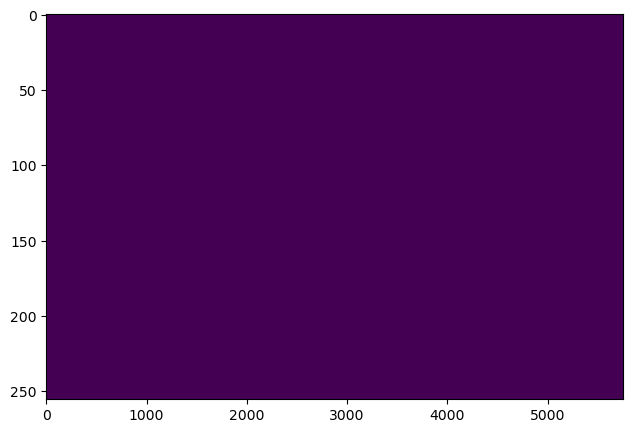

In [484]:
plt.subplots(ncols=1,nrows=1,figsize=(10,5))
plt.imshow(concatenated_spike_counts, aspect = 15, vmin = 0, vmax = 1)

In [485]:
concatenated_spike_counts_nonan_ind = np.sum(np.isinf(concatenated_spike_counts),axis = 1) == 0
concatenated_spike_counts_nonan =concatenated_spike_counts[concatenated_spike_counts_nonan_ind,:]
cell_list_nonan = [cell_list[u] for u in np.argwhere(concatenated_spike_counts_nonan_ind).ravel()]

KeyError: '[242.0, 244.0, 249.0, 254.0, 256.0, 257.0, 258.0, 264.0, 268.0, 269.0, 277.0, 278.0, 279.0, 280.0, 281.0, 289.0, 291.0, 294.0, 295.0, 298.0, 299.0, 303.0, 305.0, 312.0, 313.0, 315.0, 316.0, 318.0, 320.0, 322.0, 325.0, 329.0, 333.0, 336.0, 337.0, 338.0, 339.0, 341.0, 344.0, 347.0, 350.0, 358.0, 360.0, 364.0, 368.0, 245.0, 246.0, 250.0, 259.0, 265.0, 270.0, 274.0, 285.0, 288.0, 290.0, 292.0, 293.0, 304.0, 317.0, 326.0, 331.0, 332.0, 335.0, 340.0, 342.0, 345.0, 346.0, 351.0, 353.0, 354.0, 357.0, 363.0, 365.0, 366.0] not in index'

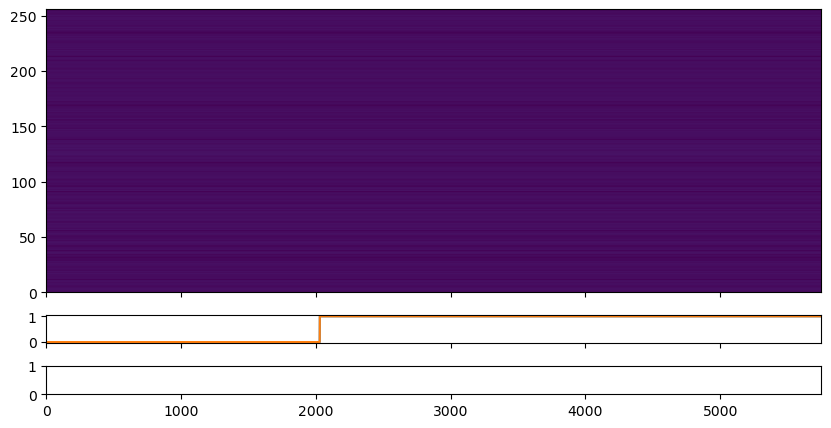

In [486]:
fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(10,5),height_ratios=[10, 1,1],sharex = True)
axes[0].imshow(concatenated_spike_counts_nonan,extent=[0, concatenated_spike_counts_nonan.shape[1], 0, concatenated_spike_counts_nonan.shape[0]],
               aspect = 'auto',vmax = 3)
axes[1].plot(concatenated_spike_counts_label)
axes[1].plot(concatenated_spike_counts_label)
axes[2].plot(np.array(ripple_times.loc[concatenated_ripple_ids].max_zscore))

fig.tight_layout()

### Do SeqNMF

In [ ]:
from time import time

from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# data engineering
# use only the positive numbers: I zero out negative entries

concatenated_spike_counts_pos = concatenated_spike_counts_nonan.copy()
concatenated_spike_counts_pos[concatenated_spike_counts_pos < 0] = 0

In [ ]:
from seqnmf import seqnmf, plot, example_data
num_components = 6
L = 10
[W, H, cost, loadings, power] = seqnmf(concatenated_spike_counts_pos[:,concatenated_spike_counts_label == 1],
                                       K=num_components, L=L, Lambda=0.01, plot_it=False)

In [ ]:
neurons_ind_seq, neurons_labels_seq = order_by_weight_SeqNMF(W)
assembly_activities_seq = H
weight_normalized = getSeqNMF_weight(W)

In [ ]:
fig, axes = plt.subplots(ncols= num_components ,nrows=1,figsize=(8,4),sharex = True)
for k in range(num_components):
    axes[k].imshow(np.squeeze(W[neurons_ind_seq,k,:]),vmax = 4)
    axes[k].set_title("W_" + str(k))

fig.tight_layout()
axes[2].text(15, -10, nwb_copy_file_name, fontsize = 15)

#### all replays

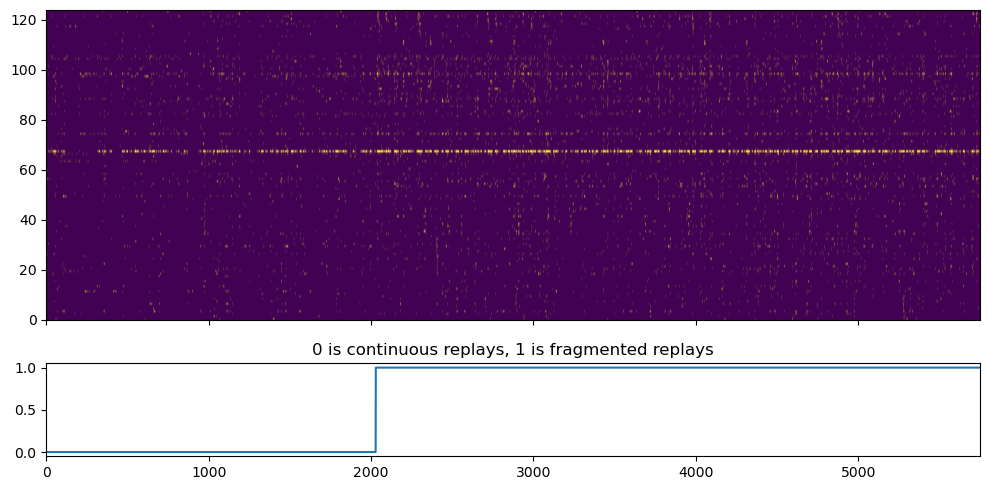

In [454]:
fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(10,5),height_ratios=[10,3],sharex = True)
axes[0].imshow(concatenated_spike_counts_pos[neurons_ind_seq,:],
               extent=[0, concatenated_spike_counts_nonan.shape[1], 0, concatenated_spike_counts_nonan.shape[0]],
               aspect = 'auto',vmax = 3)

axes[1].plot(concatenated_spike_counts_label)
axes[1].set_title("0 is continuous replays, 1 is fragmented replays")
#axes[2].plot(np.array(ripple_times.loc[concatenated_ripple_ids].max_zscore))

fig.tight_layout()

Text(0.5, 1.0, 'SeqNMF \n julio20230806_.nwb')

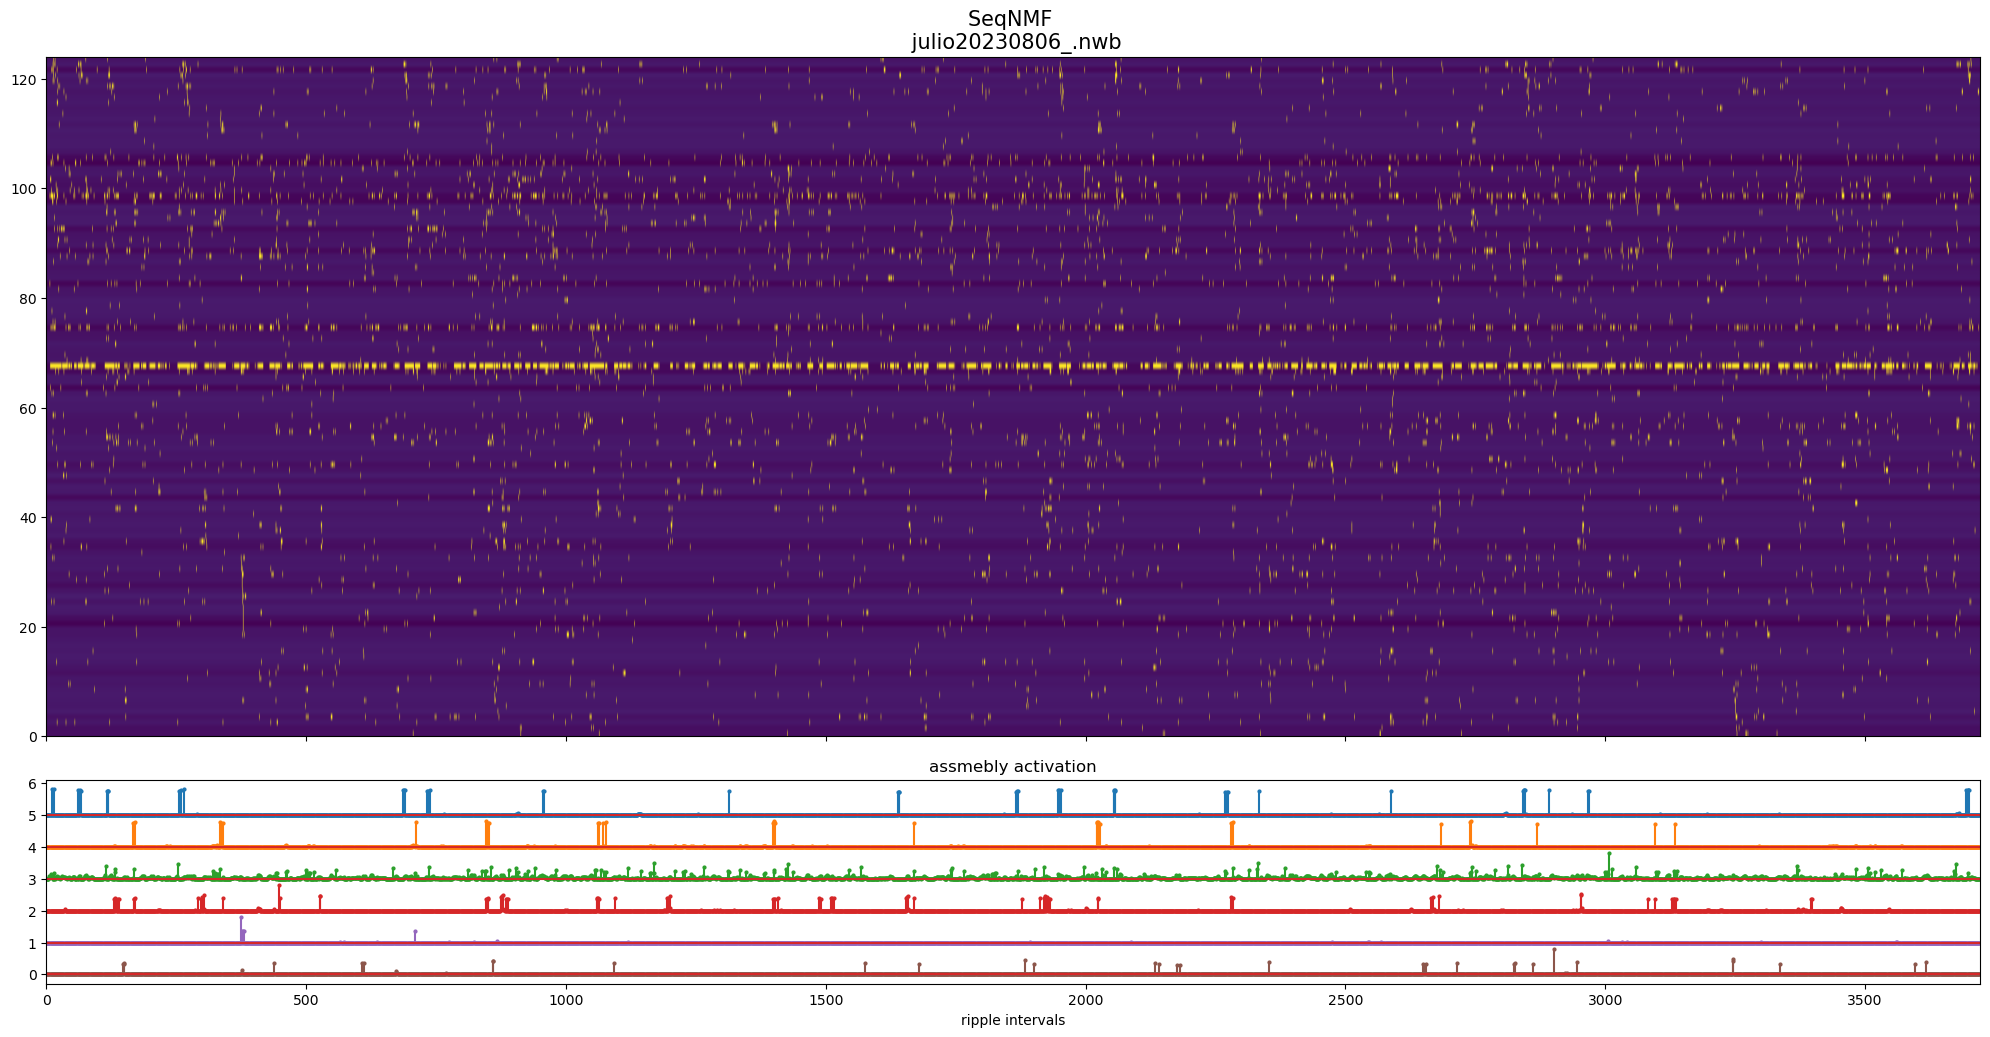

In [458]:
fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(20,10),height_ratios=[10,3],sharex = True)
axes[0].imshow(concatenated_spike_counts_nonan[neurons_ind_seq,:][:,concatenated_spike_counts_label == 1],
               extent=[0, np.sum(concatenated_spike_counts_label == 1), 0, concatenated_spike_counts_nonan.shape[0]],
               aspect = 'auto',vmax = 2)

ind = num_components - 1
for vector_ind in range(num_components):
    ic_assembly_activity = (assembly_activities_seq[vector_ind])
    ic_assembly_activity[ic_assembly_activity < 0] = 0
    offset = ind*2
    markers, stemlines, baseline = axes[1].stem(
        np.arange(np.sum(concatenated_spike_counts_label == 1)),
        (ic_assembly_activity/np.nanmax(ic_assembly_activity)) * 0.8 + ind,  linefmt = "C"+str(vector_ind),
                 bottom=ind,label = "assembly "+str(ind))
    plt.setp(markers, markersize=2)

    axes[1].set_title("assmebly activation")
    axes[1].set_ylabel('')
    ind -= 1
axes[1].set_xlabel('ripple intervals')

#axes[1].plot(concatenated_spike_counts_label)
#axes[2].plot(np.array(ripple_times.loc[concatenated_ripple_ids].max_zscore))

fig.tight_layout()
axes[0].set_title( "SeqNMF \n " + nwb_copy_file_name, fontsize = 15)

### Include some behavior information

In [459]:
neurons_ind = neurons_ind_seq
replay_ind = concatenated_spike_counts_label == 1
neurons_labels = neurons_labels_seq
replay_labels = concatenated_ripple_ids[concatenated_spike_counts_label == 1]
assembly_activities = assembly_activities_seq

In [460]:
trial_number = np.array(ripple_times.loc[concatenated_ripple_ids[replay_ind]].trial_number)
animal_location = np.array(ripple_times.loc[concatenated_ripple_ids[replay_ind]].animal_location)

In [461]:
loc2num = {"home":0,'center1':5,'center2':5,'center3':5,'center4':5,
           'well1':1,'well2':2,
          'well3':3,'well4':4,'arm0':0,'well0':0,
           'arm1':1,'arm2':2,
          'arm3':3,'arm4':4}

In [462]:
animal_location_num = [loc2num[l] for l in animal_location]

In [463]:
#log_df

In [464]:
OuterWellIndex = log_df.loc[trial_number].OuterWellIndex
current = log_df.loc[trial_number].current
future_H = log_df.loc[trial_number].future_H
future_O = log_df.loc[trial_number].future_O
past_reward = log_df.loc[trial_number].past_reward
past = log_df.loc[trial_number].past
rewardNum = log_df.loc[trial_number].rewardNum

In [465]:
spike_counts_reordered.shape

(92, 1608)

Text(0.5, 1.0, 'SeqNMF \n julio20230806_.nwb')

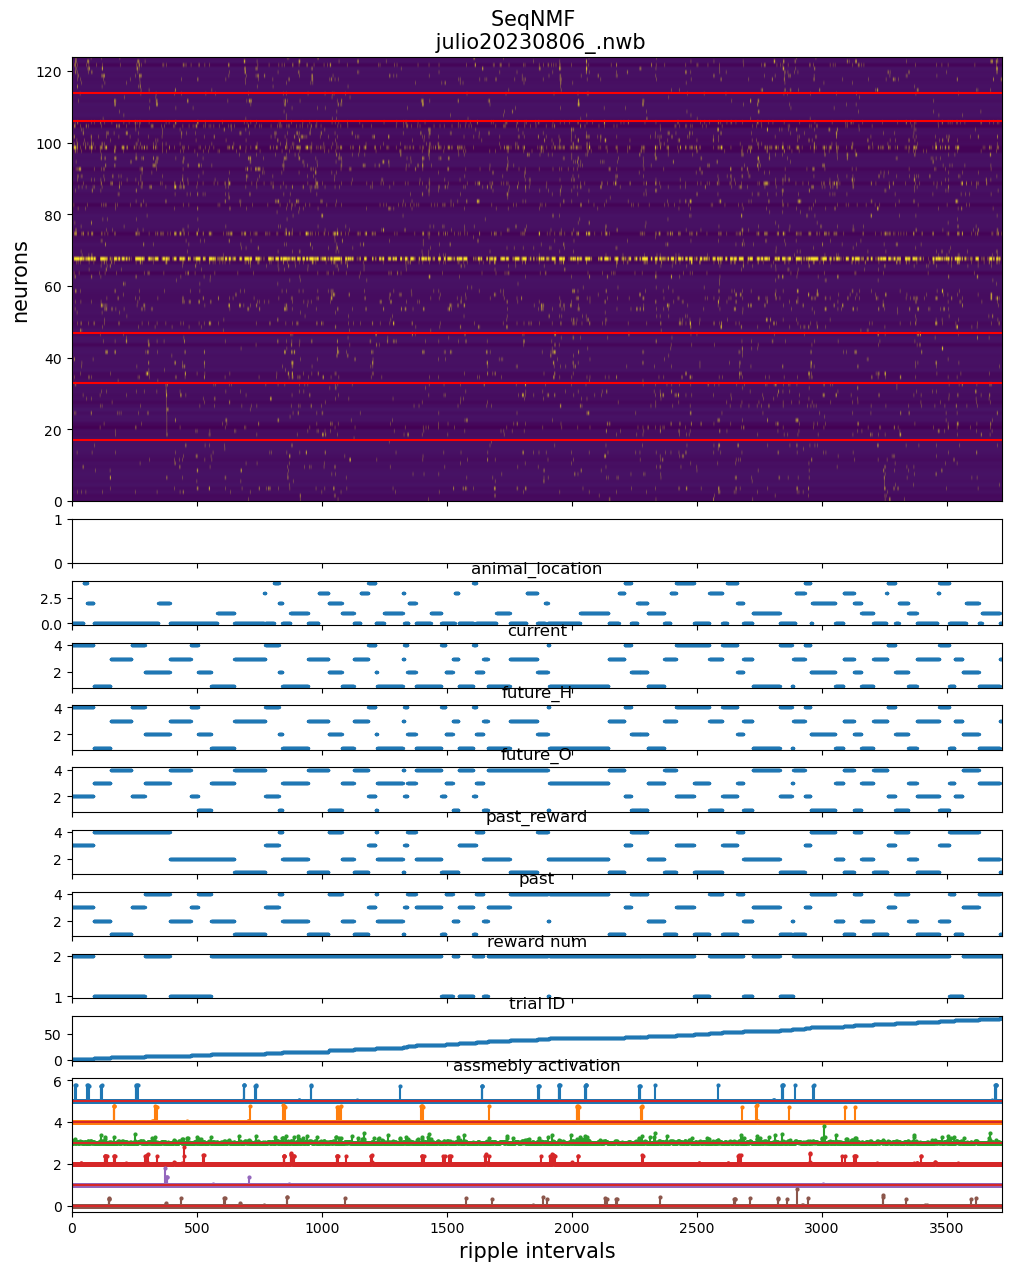

In [466]:
fig, axes = plt.subplots(ncols=1,nrows=11,figsize=(12,15),height_ratios=[10,1,1,1,1,1,1,1,1,1,3],sharex = True)
spike_counts_reordered = concatenated_spike_counts_nonan[neurons_ind,:][:,concatenated_spike_counts_label == 1]

axes[0].imshow(spike_counts_reordered,
               extent=[0, np.sum(concatenated_spike_counts_label == 1), 0, len(neurons_ind)],
               vmax = 3,
               aspect = 'auto')

# mark assembly horizonal lines
for row_ind in np.argwhere(np.diff(neurons_labels[::-1])).ravel():
    axes[0].axhline(row_ind + 1,color = 'r')
axes[0].set_ylabel('neurons',fontsize = 15) 


axes[2].scatter(np.arange(np.sum(concatenated_spike_counts_label == 1)),animal_location_num,s = 2)
axes[2].set_title("animal_location")
axes[3].scatter(np.arange(np.sum(concatenated_spike_counts_label == 1)),current,s = 2)
axes[3].set_title("current")
axes[4].scatter(np.arange(np.sum(concatenated_spike_counts_label == 1)),future_H,s = 2)
axes[4].set_title("future_H")
axes[5].scatter(np.arange(np.sum(concatenated_spike_counts_label == 1)),future_O,s = 2)
axes[5].set_title("future_O")
axes[6].scatter(np.arange(np.sum(concatenated_spike_counts_label == 1)),past_reward,s = 2)
axes[6].set_title("past_reward")
axes[7].scatter(np.arange(np.sum(concatenated_spike_counts_label == 1)),past,s = 2)
axes[7].set_title("past")
axes[8].scatter(np.arange(np.sum(concatenated_spike_counts_label == 1)),rewardNum,s = 2)
axes[8].set_title("reward num")
axes[9].scatter(np.arange(np.sum(concatenated_spike_counts_label == 1)),trial_number, s = 2)
axes[9].set_title("trial ID")

ind = num_components - 1
for vector_ind in range(num_components):
    ic_assembly_activity = assembly_activities[vector_ind]
    ic_assembly_activity[ic_assembly_activity < 0] = 0
    offset = ind*2
    markers, stemlines, baseline = axes[10].stem(
        np.arange(np.sum(concatenated_spike_counts_label == 1)),
        (ic_assembly_activity/np.nanmax(ic_assembly_activity)) * 0.8 + ind,  linefmt = "C"+str(vector_ind),
                 bottom=ind,label = "assembly "+str(ind))
    plt.setp(markers, markersize=2)

    axes[10].set_title("assmebly activation")
    axes[10].set_ylabel('')
    ind -= 1

    
#plt.legend()
plt.xlabel('ripple intervals',fontsize = 15)
axes[0].set_title( "SeqNMF \n " + nwb_copy_file_name, fontsize = 15)

### Place field Sum by Assembly

In [467]:
cell_list_ = []  
placefields = {}
placefields_im = {}
mobility_spike_counts = {}
all_spike_counts = {}
peak_frs = {}
#count_ratios = {}

for row_ind in range(len(cell_list)):
    print(row_ind)
    e = cell_list[row_ind][0]
    u = cell_list[row_ind][1]
    
    
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id=1)
    print(e,u)
    
    placefield_im, _, _1, _2, _3, _4 = place_field(
        nwb_copy_file_name, session_name, pos_name, e, u,
        curation_id = 1, nwb_units = nwb_units,
        immobility = True,
        normalize = False)
    
    placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
        nwb_copy_file_name, session_name, pos_name, e, u,
        curation_id = 1, nwb_units = nwb_units,
        immobility = False,
        normalize = True)
    if mobility_spike_count < 5:
        continue
    if all_spike_count > 20000:
        continue
        
    cell_list_.append((e,u))
    #count_ratios[(e,u)] = count_ratio[row_ind]
    
    placefields[(e,u)] = placefield
    placefields_im[(e,u)] = placefield_im
    peak_frs[(e,u)] = peak_fr
    mobility_spike_counts[(e,u)] = mobility_spike_count
    all_spike_counts[(e,u)] = all_spike_count

#cell_list = cell_list_

[2025-06-16 12:35:18,940][WARNING]: Skipped checksum for file with hash: d1aee99e-e7ff-cdc7-2ea5-f40023b929d5, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_A3HJC3N99P.nwb
[2025-06-16 12:35:18,959][WARNING]: Skipped checksum for file with hash: d1aee99e-e7ff-cdc7-2ea5-f40023b929d5, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_A3HJC3N99P.nwb
[2025-06-16 12:35:18,965][WARNING]: Skipped checksum for file with hash: d1aee99e-e7ff-cdc7-2ea5-f40023b929d5, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_A3HJC3N99P.nwb
[2025-06-16 12:35:18,996][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:19,013][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:19,018][WARNING]: Skipped checksum for file with hash: fa

0
2 4
spike num: 458


[2025-06-16 12:35:29,980][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:29,999][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:30,005][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:42,004][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:42,023][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:42,028][WARNING]: Skipped checksum for file with hash: fa

spike num: 458
1


[2025-06-16 12:35:42,188][WARNING]: Skipped checksum for file with hash: d1aee99e-e7ff-cdc7-2ea5-f40023b929d5, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_A3HJC3N99P.nwb
[2025-06-16 12:35:42,211][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:42,226][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:42,231][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:42,254][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:42,270][WARNING]: Skipped checksum for file with hash: 01

2 6
spike num: 763
spike num: 763


[2025-06-16 12:35:42,417][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:42,436][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:42,443][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:42,544][WARNING]: Skipped checksum for file with hash: d1aee99e-e7ff-cdc7-2ea5-f40023b929d5, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_A3HJC3N99P.nwb
[2025-06-16 12:35:42,562][WARNING]: Skipped checksum for file with hash: d1aee99e-e7ff-cdc7-2ea5-f40023b929d5, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_A3HJC3N99P.nwb
[2025-06-16 12:35:42,569][WARNING]: Skipped checksum for file with hash: d1

2
2 7
spike num: 5996


[2025-06-16 12:35:42,766][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:42,783][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:42,788][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:42,812][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:42,829][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:42,834][WARNING]: Skipped checksum for file with hash: 01

spike num: 5996
3


[2025-06-16 12:35:42,961][WARNING]: Skipped checksum for file with hash: d1aee99e-e7ff-cdc7-2ea5-f40023b929d5, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_A3HJC3N99P.nwb
[2025-06-16 12:35:42,967][WARNING]: Skipped checksum for file with hash: d1aee99e-e7ff-cdc7-2ea5-f40023b929d5, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_A3HJC3N99P.nwb
[2025-06-16 12:35:42,989][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,005][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,011][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,036][WARNING]: Skipped checksum for file with hash: 01

2 10
spike num: 675
spike num: 675


[2025-06-16 12:35:43,174][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,198][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:43,214][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:43,219][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:43,314][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:43,330][WARNING]: Skipped checksum for file with hash: 3f

4
3 2
spike num: 415


[2025-06-16 12:35:43,515][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,531][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,536][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,562][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:43,577][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:43,582][WARNING]: Skipped checksum for file with hash: 01

spike num: 415
5


[2025-06-16 12:35:43,699][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:43,722][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,738][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,743][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:43,767][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:43,783][WARNING]: Skipped checksum for file with hash: 01

3 3
spike num: 241
spike num: 241


[2025-06-16 12:35:43,922][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:43,937][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:43,942][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:44,030][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:44,047][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:44,053][WARNING]: Skipped checksum for file with hash: 3f

6
3 4
spike num: 1459
spike num: 1459


[2025-06-16 12:35:44,231][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:44,246][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:44,252][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:44,278][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:44,293][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:44,297][WARNING]: Skipped checksum for file with hash: 01

7
3 5
spike num: 1855


[2025-06-16 12:35:44,623][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:44,637][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:44,641][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:44,661][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:44,672][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:44,676][WARNING]: Skipped checksum for file with hash: 01

spike num: 1855
8
3 6
spike num: 246


[2025-06-16 12:35:44,812][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:44,816][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:44,831][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:44,840][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:44,844][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:44,919][WARNING]: Skipped checksum for file with hash: fa

spike num: 246


[2025-06-16 12:35:45,127][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:45,145][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:45,151][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:45,172][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,188][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,193][WARNING]: Skipped checksum for file with hash: fa

9
3 8
spike num: 446


[2025-06-16 12:35:45,332][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,349][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,354][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,378][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:45,395][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:45,399][WARNING]: Skipped checksum for file with hash: 01

spike num: 446
10
3 9
spike num: 988


[2025-06-16 12:35:45,534][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,550][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,555][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,582][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:45,598][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:45,603][WARNING]: Skipped checksum for file with hash: 01

spike num: 988
11


[2025-06-16 12:35:45,890][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:45,911][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,927][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,932][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:45,955][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:45,970][WARNING]: Skipped checksum for file with hash: 01

3 10
spike num: 330
spike num: 330


[2025-06-16 12:35:46,097][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:46,124][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:46,140][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:46,145][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:46,278][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:46,298][WARNING]: Skipped checksum for file with hash: 3f

12
3 13
spike num: 1538


[2025-06-16 12:35:46,493][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:46,508][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:46,513][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:46,535][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:46,550][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:46,554][WARNING]: Skipped checksum for file with hash: 01

spike num: 1538
13
3 14
spike num: 531


[2025-06-16 12:35:46,683][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:46,697][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:46,702][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:46,724][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:46,738][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:46,743][WARNING]: Skipped checksum for file with hash: 01

spike num: 531
14


[2025-06-16 12:35:47,016][WARNING]: Skipped checksum for file with hash: 3f3642ba-9b5b-2cff-9c76-ca31d85c9d5f, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_C5PNIV3YDW.nwb
[2025-06-16 12:35:47,041][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,058][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,063][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,088][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:47,104][WARNING]: Skipped checksum for file with hash: 01

3 15
spike num: 121
spike num: 121


[2025-06-16 12:35:47,223][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,228][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,252][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:47,270][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:47,276][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:47,349][WARNING]: Skipped checksum for file with hash: 3f

15
3 16
spike num: 451
spike num: 451


[2025-06-16 12:35:47,548][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,564][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,569][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,594][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:47,610][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:47,615][WARNING]: Skipped checksum for file with hash: 01

16
6 2
spike num: 890


[2025-06-16 12:35:47,922][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,938][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,943][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:47,966][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:47,983][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:47,987][WARNING]: Skipped checksum for file with hash: 01

spike num: 890
17


[2025-06-16 12:35:48,121][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:48,137][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:48,141][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:48,164][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:48,179][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:48,183][WARNING]: Skipped checksum for file with hash: 01

6 3
spike num: 53
spike num: 53


[2025-06-16 12:35:48,321][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:48,336][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:48,341][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:48,431][WARNING]: Skipped checksum for file with hash: 632a4658-6b63-9ccb-a284-dae4cf7146e3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_XJ7EMU8DOU.nwb
[2025-06-16 12:35:48,448][WARNING]: Skipped checksum for file with hash: 632a4658-6b63-9ccb-a284-dae4cf7146e3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_XJ7EMU8DOU.nwb
[2025-06-16 12:35:48,453][WARNING]: Skipped checksum for file with hash: 63

18
6 4
spike num: 334
spike num: 334


[2025-06-16 12:35:48,626][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:48,641][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:48,646][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:48,671][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:48,689][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:48,693][WARNING]: Skipped checksum for file with hash: 01

19
6 5
spike num: 338
spike num: 338


[2025-06-16 12:35:48,980][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:48,999][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:49,005][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:49,035][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:49,053][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:49,060][WARNING]: Skipped checksum for file with hash: 01

20
6 6
spike num: 434


[2025-06-16 12:35:49,372][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:49,387][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:49,391][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:49,414][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:49,429][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:49,435][WARNING]: Skipped checksum for file with hash: 01

spike num: 434
21
6 7
spike num: 466


[2025-06-16 12:35:49,568][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:49,584][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:49,588][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:49,613][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:49,628][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:49,632][WARNING]: Skipped checksum for file with hash: 01

spike num: 466
22
6 11
spike num: 445


[2025-06-16 12:35:49,908][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:49,912][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:49,987][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,005][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,011][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,038][WARNING]: Skipped checksum for file with hash: 01

spike num: 445
23


[2025-06-16 12:35:50,180][WARNING]: Skipped checksum for file with hash: 632a4658-6b63-9ccb-a284-dae4cf7146e3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_XJ7EMU8DOU.nwb
[2025-06-16 12:35:50,187][WARNING]: Skipped checksum for file with hash: 632a4658-6b63-9ccb-a284-dae4cf7146e3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_XJ7EMU8DOU.nwb
[2025-06-16 12:35:50,212][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,231][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,237][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,263][WARNING]: Skipped checksum for file with hash: 01

6 12
spike num: 1210
spike num: 1210


[2025-06-16 12:35:50,395][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,401][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,427][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:50,447][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:50,453][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:50,549][WARNING]: Skipped checksum for file with hash: 63

24
6 13
spike num: 499


[2025-06-16 12:35:50,820][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,840][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,848][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:50,879][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:50,901][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:50,909][WARNING]: Skipped checksum for file with hash: 01

spike num: 499
25


[2025-06-16 12:35:51,017][WARNING]: Skipped checksum for file with hash: 632a4658-6b63-9ccb-a284-dae4cf7146e3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_XJ7EMU8DOU.nwb
[2025-06-16 12:35:51,040][WARNING]: Skipped checksum for file with hash: 632a4658-6b63-9ccb-a284-dae4cf7146e3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_XJ7EMU8DOU.nwb
[2025-06-16 12:35:51,049][WARNING]: Skipped checksum for file with hash: 632a4658-6b63-9ccb-a284-dae4cf7146e3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_XJ7EMU8DOU.nwb
[2025-06-16 12:35:51,079][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,101][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,108][WARNING]: Skipped checksum for file with hash: fa

6 14
spike num: 278


[2025-06-16 12:35:51,290][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,311][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,319][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,351][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:51,374][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:51,382][WARNING]: Skipped checksum for file with hash: 01

spike num: 278


[2025-06-16 12:35:51,496][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:51,519][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:51,528][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:51,562][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,586][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,594][WARNING]: Skipped checksum for file with hash: fa

26
7 4
spike num: 4343


[2025-06-16 12:35:51,811][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,832][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,840][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:51,872][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:51,895][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:51,903][WARNING]: Skipped checksum for file with hash: 01

spike num: 4343


[2025-06-16 12:35:52,026][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:52,047][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:52,055][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:52,085][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,108][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,118][WARNING]: Skipped checksum for file with hash: fa

27
7 8
spike num: 2961


[2025-06-16 12:35:52,329][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,350][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,358][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,390][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:52,413][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:52,421][WARNING]: Skipped checksum for file with hash: 01

spike num: 2961


[2025-06-16 12:35:52,539][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:52,562][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:52,570][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:52,602][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,625][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,633][WARNING]: Skipped checksum for file with hash: fa

28
7 9
spike num: 3803


[2025-06-16 12:35:52,827][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,849][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,860][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:52,885][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:52,902][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:52,907][WARNING]: Skipped checksum for file with hash: 01

spike num: 3803
29


[2025-06-16 12:35:53,020][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:53,026][WARNING]: Skipped checksum for file with hash: dfdffe8f-0c6f-7ce2-3d79-ef98c2dc2972, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_YI48JC2TRK.nwb
[2025-06-16 12:35:53,050][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:53,072][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:53,077][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:53,101][WARNING]: Skipped checksum for file with hash: 01

7 11
spike num: 134
spike num: 134


[2025-06-16 12:35:53,252][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:53,269][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:53,276][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:53,348][WARNING]: Skipped checksum for file with hash: 5b682acf-c6cc-25fc-ed0b-85ced1adc35b, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_AY3SFKCUX7.nwb
[2025-06-16 12:35:53,367][WARNING]: Skipped checksum for file with hash: 5b682acf-c6cc-25fc-ed0b-85ced1adc35b, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_AY3SFKCUX7.nwb
[2025-06-16 12:35:53,373][WARNING]: Skipped checksum for file with hash: 5b

30
8 2
spike num: 7278


[2025-06-16 12:35:53,575][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:53,592][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:53,597][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:53,621][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:53,637][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:53,642][WARNING]: Skipped checksum for file with hash: 01

spike num: 7278
31
12 4
spike num: 499


[2025-06-16 12:35:53,772][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:53,791][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:53,795][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:53,819][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:53,838][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:53,843][WARNING]: Skipped checksum for file with hash: 01

spike num: 499
32


[2025-06-16 12:35:54,135][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,154][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,160][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,187][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,204][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,208][WARNING]: Skipped checksum for file with hash: 01

12 5
spike num: 325
spike num: 325


[2025-06-16 12:35:54,318][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,323][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,346][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,363][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,367][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,449][WARNING]: Skipped checksum for file with hash: 60

33
12 8
spike num: 3307


[2025-06-16 12:35:54,678][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,696][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,700][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,724][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,741][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,745][WARNING]: Skipped checksum for file with hash: 01

spike num: 3307
34
12 9
spike num: 67


[2025-06-16 12:35:54,866][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,870][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:54,885][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,895][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,900][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:54,981][WARNING]: Skipped checksum for file with hash: fa

spike num: 67
35
12 10
spike num: 312


[2025-06-16 12:35:55,181][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:55,198][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:55,204][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:55,296][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:55,313][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:55,319][WARNING]: Skipped checksum for file with hash: fa

spike num: 312
36
12 14
spike num: 2197


[2025-06-16 12:35:55,491][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:55,505][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:55,509][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:55,530][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:55,544][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:55,548][WARNING]: Skipped checksum for file with hash: 01

spike num: 2197
37


[2025-06-16 12:35:55,803][WARNING]: Skipped checksum for file with hash: 60bff351-0cf3-6399-fb56-058a61d1a89e, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_9UYUOWJ4C4.nwb
[2025-06-16 12:35:55,826][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:55,841][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:55,846][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:55,868][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:55,883][WARNING]: Skipped checksum for file with hash: 01

12 15
spike num: 1814
spike num: 1814


[2025-06-16 12:35:56,019][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:56,037][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:56,043][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:56,141][WARNING]: Skipped checksum for file with hash: 60bff351-0cf3-6399-fb56-058a61d1a89e, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_9UYUOWJ4C4.nwb
[2025-06-16 12:35:56,157][WARNING]: Skipped checksum for file with hash: 60bff351-0cf3-6399-fb56-058a61d1a89e, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_9UYUOWJ4C4.nwb
[2025-06-16 12:35:56,162][WARNING]: Skipped checksum for file with hash: 60

38
12 16
spike num: 752


[2025-06-16 12:35:56,343][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:56,359][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:56,365][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:56,391][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:56,409][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:56,416][WARNING]: Skipped checksum for file with hash: 01

spike num: 752
39


[2025-06-16 12:35:56,532][WARNING]: Skipped checksum for file with hash: 60bff351-0cf3-6399-fb56-058a61d1a89e, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_9UYUOWJ4C4.nwb
[2025-06-16 12:35:56,537][WARNING]: Skipped checksum for file with hash: 60bff351-0cf3-6399-fb56-058a61d1a89e, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_9UYUOWJ4C4.nwb
[2025-06-16 12:35:56,559][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:56,574][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:56,579][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:56,602][WARNING]: Skipped checksum for file with hash: 01

12 17
spike num: 695
spike num: 695


[2025-06-16 12:35:56,754][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:56,772][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:56,778][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:56,870][WARNING]: Skipped checksum for file with hash: 60bff351-0cf3-6399-fb56-058a61d1a89e, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_9UYUOWJ4C4.nwb
[2025-06-16 12:35:56,887][WARNING]: Skipped checksum for file with hash: 60bff351-0cf3-6399-fb56-058a61d1a89e, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_9UYUOWJ4C4.nwb
[2025-06-16 12:35:56,892][WARNING]: Skipped checksum for file with hash: 60

40
12 18
spike num: 2638
spike num: 2638


[2025-06-16 12:35:57,069][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,084][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,089][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,112][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:57,130][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:57,136][WARNING]: Skipped checksum for file with hash: 01

41
15 2
spike num: 216
spike num: 216


[2025-06-16 12:35:57,418][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,433][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,437][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,459][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:57,474][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:57,478][WARNING]: Skipped checksum for file with hash: 01

42
15 3
spike num: 4989


[2025-06-16 12:35:57,754][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,769][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,774][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,796][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:57,810][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:57,814][WARNING]: Skipped checksum for file with hash: 01

spike num: 4989
43
15 4
spike num: 194


[2025-06-16 12:35:57,951][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,969][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:57,975][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:58,002][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:58,021][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:58,026][WARNING]: Skipped checksum for file with hash: 01

spike num: 194
44
15 5
spike num: 1320


[2025-06-16 12:35:58,299][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:58,317][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:58,323][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:58,351][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:58,370][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:58,377][WARNING]: Skipped checksum for file with hash: 01

spike num: 1320
45
15 6
spike num: 222


[2025-06-16 12:35:58,681][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:58,687][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:58,711][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:58,730][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:58,736][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:58,834][WARNING]: Skipped checksum for file with hash: fa

spike num: 222
46
15 8
spike num: 1220


[2025-06-16 12:35:59,029][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:59,034][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:59,055][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:59,071][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:59,077][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:59,171][WARNING]: Skipped checksum for file with hash: fa

spike num: 1220
47
15 9
spike num: 2789


[2025-06-16 12:35:59,364][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:59,379][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:59,383][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:59,405][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:59,421][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:59,425][WARNING]: Skipped checksum for file with hash: 01

spike num: 2789
48


[2025-06-16 12:35:59,682][WARNING]: Skipped checksum for file with hash: 83849814-8151-b084-4de5-49aa0aa642ff, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_K9VNM44NVW.nwb
[2025-06-16 12:35:59,702][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:59,717][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:59,723][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:35:59,747][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:59,760][WARNING]: Skipped checksum for file with hash: 01

15 11
spike num: 1420
spike num: 1420


[2025-06-16 12:35:59,888][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:59,904][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:59,909][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:35:59,998][WARNING]: Skipped checksum for file with hash: 83849814-8151-b084-4de5-49aa0aa642ff, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_K9VNM44NVW.nwb
[2025-06-16 12:36:00,008][WARNING]: Skipped checksum for file with hash: 83849814-8151-b084-4de5-49aa0aa642ff, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_K9VNM44NVW.nwb
[2025-06-16 12:36:00,012][WARNING]: Skipped checksum for file with hash: 83

49
15 12
spike num: 788
spike num: 788


[2025-06-16 12:36:00,254][WARNING]: Skipped checksum for file with hash: 83849814-8151-b084-4de5-49aa0aa642ff, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_K9VNM44NVW.nwb
[2025-06-16 12:36:00,269][WARNING]: Skipped checksum for file with hash: 83849814-8151-b084-4de5-49aa0aa642ff, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_K9VNM44NVW.nwb
[2025-06-16 12:36:00,275][WARNING]: Skipped checksum for file with hash: 83849814-8151-b084-4de5-49aa0aa642ff, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_K9VNM44NVW.nwb
[2025-06-16 12:36:00,298][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:00,314][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:00,321][WARNING]: Skipped checksum for file with hash: fa

50
15 13
spike num: 219
spike num: 219


[2025-06-16 12:36:00,455][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:00,470][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:00,475][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:00,497][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:00,513][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:00,517][WARNING]: Skipped checksum for file with hash: 01

51
15 15
spike num: 2522


[2025-06-16 12:36:00,821][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:00,837][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:00,841][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:00,864][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:00,878][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:00,882][WARNING]: Skipped checksum for file with hash: 01

spike num: 2522
52


[2025-06-16 12:36:01,023][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,040][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,047][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,071][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:01,085][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:01,090][WARNING]: Skipped checksum for file with hash: 01

15 18
spike num: 1018
spike num: 1018


[2025-06-16 12:36:01,207][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,231][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:01,246][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:01,251][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:01,341][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:01,357][WARNING]: Skipped checksum for file with hash: 90

53
20 2
spike num: 9926


[2025-06-16 12:36:01,566][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,581][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,586][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,610][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:01,624][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:01,629][WARNING]: Skipped checksum for file with hash: 01

spike num: 9926
54


[2025-06-16 12:36:01,760][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:01,765][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:01,786][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,802][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,806][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,829][WARNING]: Skipped checksum for file with hash: 01

20 3
spike num: 7292
spike num: 7292


[2025-06-16 12:36:01,980][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:01,985][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:02,008][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:02,023][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:02,027][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:02,132][WARNING]: Skipped checksum for file with hash: 90

55
20 4
spike num: 740
spike num: 740


[2025-06-16 12:36:02,320][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:02,324][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:02,346][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:02,360][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:02,364][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:02,449][WARNING]: Skipped checksum for file with hash: 90

56
20 6
spike num: 85
spike num: 85


[2025-06-16 12:36:02,637][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:02,651][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:02,657][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:02,682][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:02,698][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:02,702][WARNING]: Skipped checksum for file with hash: 01

57
20 7
spike num: 7665


[2025-06-16 12:36:02,999][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:03,016][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:03,020][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:03,047][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:03,063][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:03,067][WARNING]: Skipped checksum for file with hash: 01

spike num: 7665
58


[2025-06-16 12:36:03,188][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:03,194][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:03,215][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:03,230][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:03,235][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:03,260][WARNING]: Skipped checksum for file with hash: 01

20 9
spike num: 449
spike num: 449


[2025-06-16 12:36:03,416][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:03,432][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:03,437][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:03,523][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:03,543][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:03,551][WARNING]: Skipped checksum for file with hash: 90

59
20 10
spike num: 178


[2025-06-16 12:36:03,807][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:03,828][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:03,836][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:03,866][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:03,886][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:03,894][WARNING]: Skipped checksum for file with hash: 01

spike num: 178


[2025-06-16 12:36:04,048][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:04,070][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:04,077][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:04,106][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,127][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,133][WARNING]: Skipped checksum for file with hash: fa

60
20 11
spike num: 155


[2025-06-16 12:36:04,341][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,360][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,367][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,399][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:04,417][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:04,423][WARNING]: Skipped checksum for file with hash: 01

spike num: 155


[2025-06-16 12:36:04,584][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:04,602][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:04,608][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:04,632][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,651][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,657][WARNING]: Skipped checksum for file with hash: fa

61
20 12
spike num: 5711


[2025-06-16 12:36:04,835][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,852][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,858][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:04,882][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:04,898][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:04,905][WARNING]: Skipped checksum for file with hash: 01

spike num: 5711
62


[2025-06-16 12:36:05,019][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:05,024][WARNING]: Skipped checksum for file with hash: 909d1ed4-215f-3077-e2cc-040bab1d39b8, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_WYLDTH66JI.nwb
[2025-06-16 12:36:05,046][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:05,061][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:05,066][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:05,079][WARNING]: Skipped checksum for file with hash: 01

20 14
spike num: 1436
spike num: 1436


[2025-06-16 12:36:05,236][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:05,240][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:05,333][WARNING]: Skipped checksum for file with hash: 42718c5b-5273-8369-a4bb-f682fbbc63f3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_Q91ZBDVSXV.nwb
[2025-06-16 12:36:05,349][WARNING]: Skipped checksum for file with hash: 42718c5b-5273-8369-a4bb-f682fbbc63f3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_Q91ZBDVSXV.nwb
[2025-06-16 12:36:05,354][WARNING]: Skipped checksum for file with hash: 42718c5b-5273-8369-a4bb-f682fbbc63f3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_Q91ZBDVSXV.nwb
[2025-06-16 12:36:05,376][WARNING]: Skipped checksum for file with hash: fa

63
22 3
spike num: 321
spike num: 321


[2025-06-16 12:36:05,527][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:05,544][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:05,548][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:05,571][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:05,586][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:05,591][WARNING]: Skipped checksum for file with hash: 01

64
22 7
spike num: 1138
spike num: 1138


[2025-06-16 12:36:05,879][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:05,896][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:05,901][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:05,925][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:05,941][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:05,946][WARNING]: Skipped checksum for file with hash: 01

65
22 8
spike num: 1444


[2025-06-16 12:36:06,235][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:06,251][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:06,256][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:06,278][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:06,294][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:06,299][WARNING]: Skipped checksum for file with hash: 01

spike num: 1444
66
22 9
spike num: 527


[2025-06-16 12:36:06,436][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:06,452][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:06,457][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:06,481][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:06,496][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:06,501][WARNING]: Skipped checksum for file with hash: 01

spike num: 527


[2025-06-16 12:36:06,855][WARNING]: Skipped checksum for file with hash: 42718c5b-5273-8369-a4bb-f682fbbc63f3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_Q91ZBDVSXV.nwb
[2025-06-16 12:36:06,875][WARNING]: Skipped checksum for file with hash: 42718c5b-5273-8369-a4bb-f682fbbc63f3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_Q91ZBDVSXV.nwb
[2025-06-16 12:36:06,885][WARNING]: Skipped checksum for file with hash: 42718c5b-5273-8369-a4bb-f682fbbc63f3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_Q91ZBDVSXV.nwb
[2025-06-16 12:36:06,910][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:06,929][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:06,935][WARNING]: Skipped checksum for file with hash: fa

67
22 10
spike num: 2365


[2025-06-16 12:36:07,162][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,180][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,186][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,215][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:07,234][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:07,241][WARNING]: Skipped checksum for file with hash: 01

spike num: 2365


[2025-06-16 12:36:07,415][WARNING]: Skipped checksum for file with hash: 42718c5b-5273-8369-a4bb-f682fbbc63f3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_Q91ZBDVSXV.nwb
[2025-06-16 12:36:07,437][WARNING]: Skipped checksum for file with hash: 42718c5b-5273-8369-a4bb-f682fbbc63f3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_Q91ZBDVSXV.nwb
[2025-06-16 12:36:07,444][WARNING]: Skipped checksum for file with hash: 42718c5b-5273-8369-a4bb-f682fbbc63f3, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_Q91ZBDVSXV.nwb
[2025-06-16 12:36:07,465][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,481][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,487][WARNING]: Skipped checksum for file with hash: fa

68
22 11
spike num: 1138


[2025-06-16 12:36:07,625][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,642][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,647][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,670][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:07,685][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:07,690][WARNING]: Skipped checksum for file with hash: 01

spike num: 1138
69
26 3
spike num: 1917


[2025-06-16 12:36:07,825][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,840][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,844][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:07,866][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:07,882][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:07,887][WARNING]: Skipped checksum for file with hash: 01

spike num: 1917
70


[2025-06-16 12:36:08,168][WARNING]: Skipped checksum for file with hash: 11218781-a22c-9a04-1ea1-acd9ec42e38d, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_5WV8PUJNJX.nwb
[2025-06-16 12:36:08,190][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:08,207][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:08,212][WARNING]: Skipped checksum for file with hash: faaa74d9-430d-14c0-5c2f-07d3f4c51be8, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_O6F0I9FPFR.nwb
[2025-06-16 12:36:08,234][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:08,252][WARNING]: Skipped checksum for file with hash: 01

26 6
spike num: 249
spike num: 249


[2025-06-16 12:36:08,395][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:08,412][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:08,417][WARNING]: Skipped checksum for file with hash: 01a0b90a-a2d5-8149-76a7-71c6d21a7daf, and path: /stelmo/nwb/analysis/julio20230806/julio20230806_7Z97CV5O6Z.nwb
[2025-06-16 12:36:08,505][WARNING]: Skipped checksum for file with hash: 002fe249-f156-f4bc-6ffa-9d143d8fa215, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_JTGGLCM1SP.nwb
[2025-06-16 12:36:08,522][WARNING]: Skipped checksum for file with hash: 002fe249-f156-f4bc-6ffa-9d143d8fa215, and path: /stelmo/nwb/analysis/Julio20230806/Julio20230806_JTGGLCM1SP.nwb


71



KeyboardInterrupt



In [ ]:
baseline = get_baseline(nwb_copy_file_name, session_name,
                        curation_id = 1, delta_t = 0.05)

In [ ]:
def plot_assembly_placefield(neurons_labels_all_assembly,neurons_ind_all_assembly,
                             ic_vectors,
                             cell_list_nonan,placefields,baseline):

    row_num = int(np.ceil(len(np.unique(neurons_labels_all_assembly))/5))
    fig, axes = plt.subplots(row_num,5, figsize = (13,8 * row_num/3), squeeze = True)
    
    # sum each assembly's place field
    for assembly in np.unique(neurons_labels_all_assembly):
        cell_list_assembly = [cell_list_nonan[u] for u in neurons_ind_all_assembly[neurons_labels_all_assembly == assembly]]
        weights = np.array([ic_vectors[int(assembly)][u] for u in neurons_ind_all_assembly[neurons_labels_all_assembly == assembly]])
        #cell_list_assembly = cell_list_nonan
        #weights = ic_vectors[int(assembly)]
        weights = weights / np.sum(weights)
    
        place_fields_list = []
        
        for p in np.arange(len(cell_list_assembly)):
            
            (e,u) = cell_list_assembly[p]
            weight = weights[p]
            try:
                place_fields_list.append((placefields[(e,u)] - baseline[(e,u)][0]) / baseline[(e,u)][1] * weight)
            except:
                pass
        if len(place_fields_list) == 0:
            continue
        all_place_fields_sum = np.array(place_fields_list)
        all_place_fields_sum = np.sum(all_place_fields_sum, axis = 0)
        
        axes[np.unravel_index(int(assembly), axes.shape)].imshow(all_place_fields_sum)
        axes[np.unravel_index(int(assembly), axes.shape)].set_title("assembly "+str(int(assembly)) +
                                                                    "\n # of neurons" + str(len(weights)))


In [ ]:
neurons_labels_seq

In [ ]:
plot_assembly_placefield(neurons_labels_seq,neurons_ind_seq,
                         weight_normalized,cell_list_nonan,placefields,baseline)

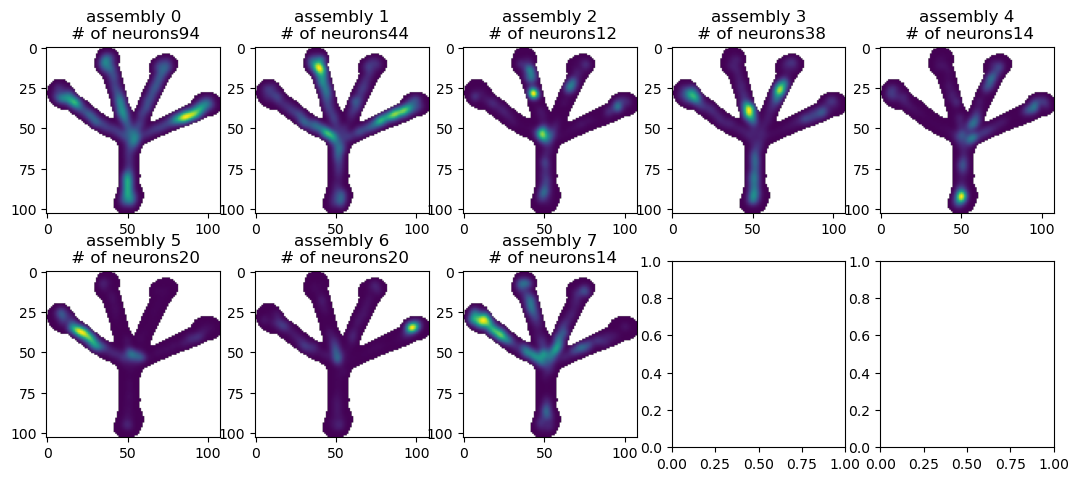

In [320]:
plot_assembly_placefield(neurons_labels_ic,neurons_ind_ic,
                         ic_vectors,cell_list_nonan,placefields,baseline)

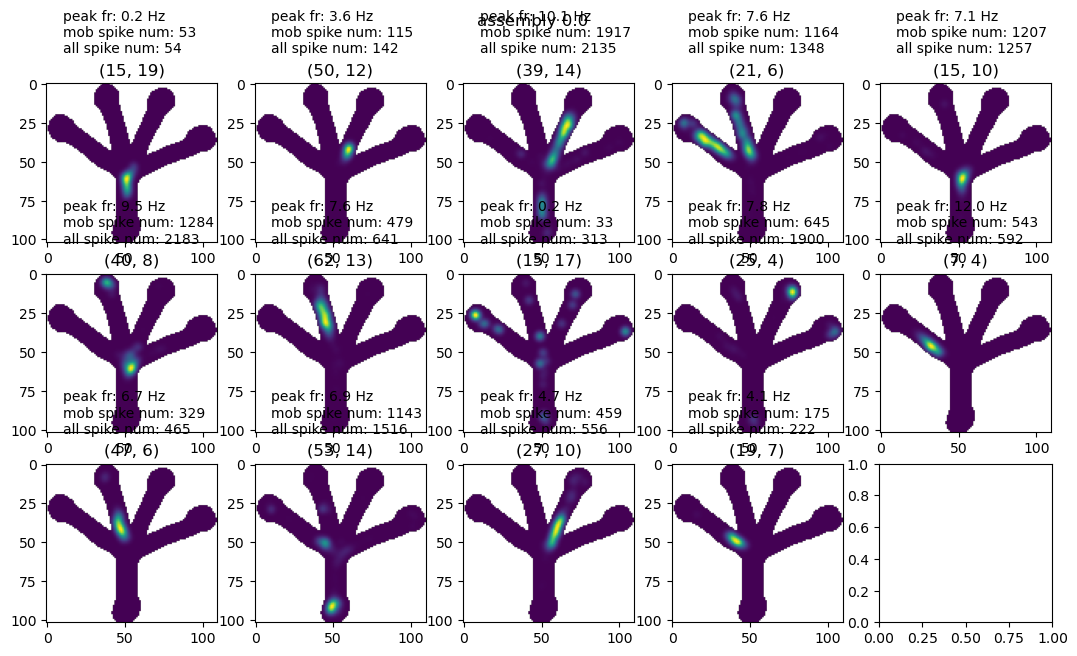

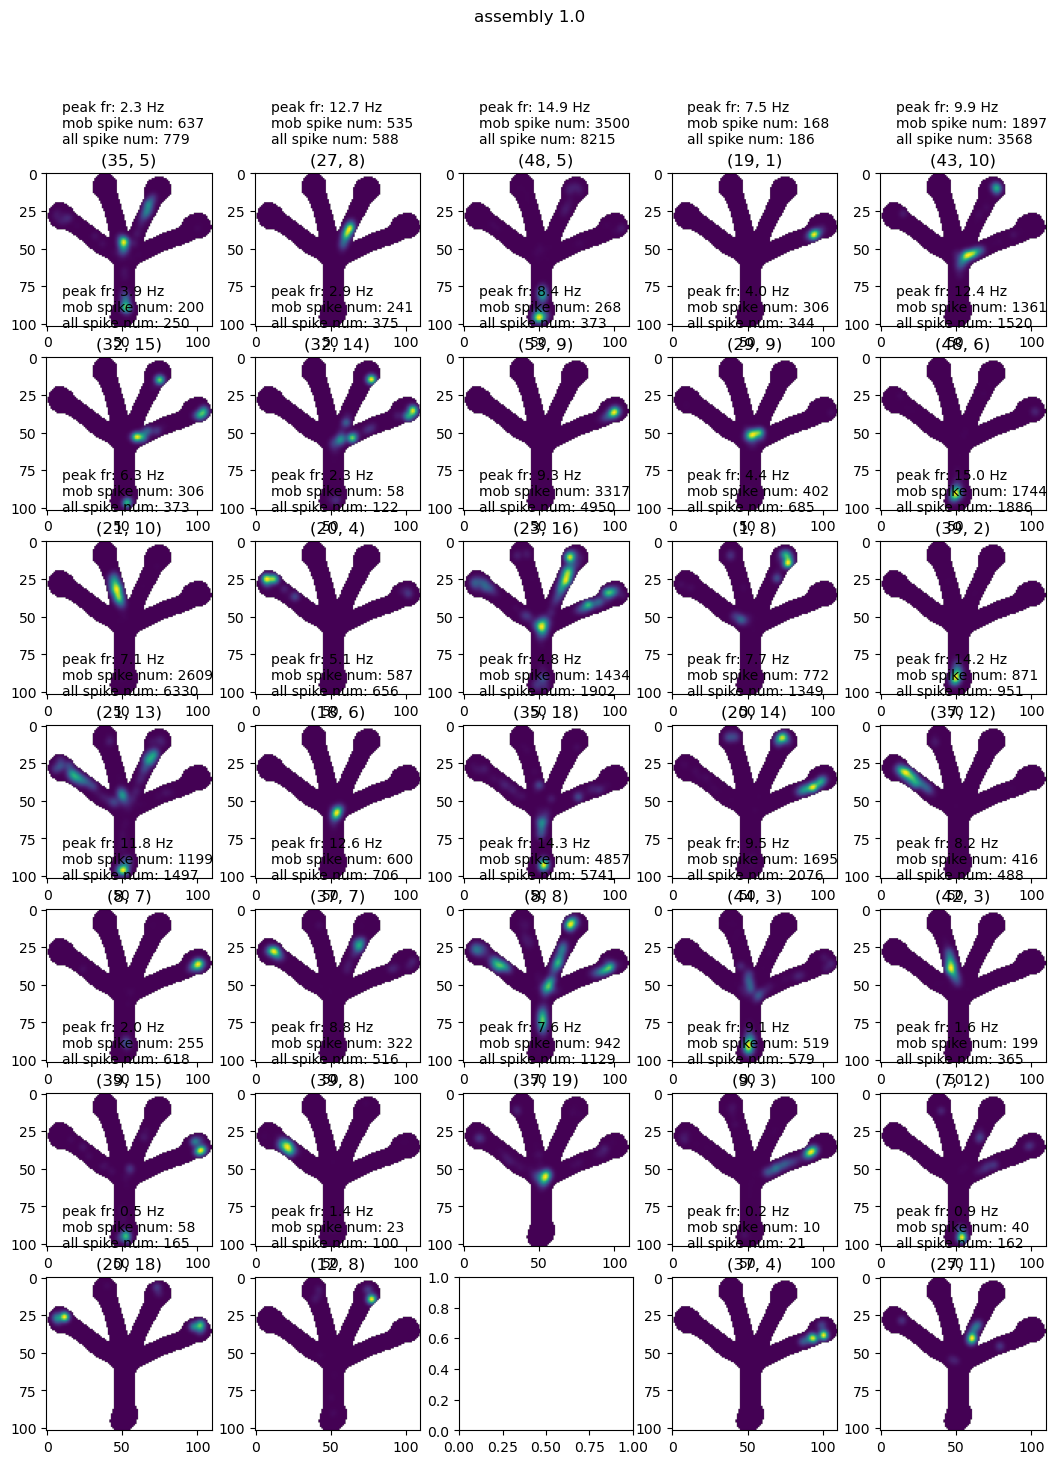

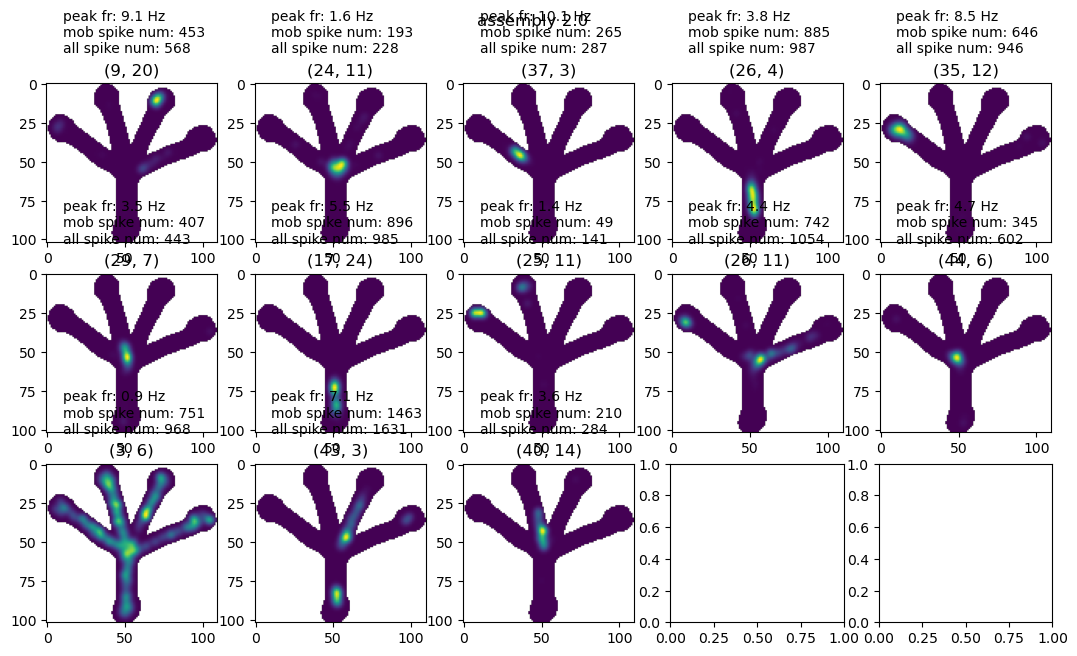

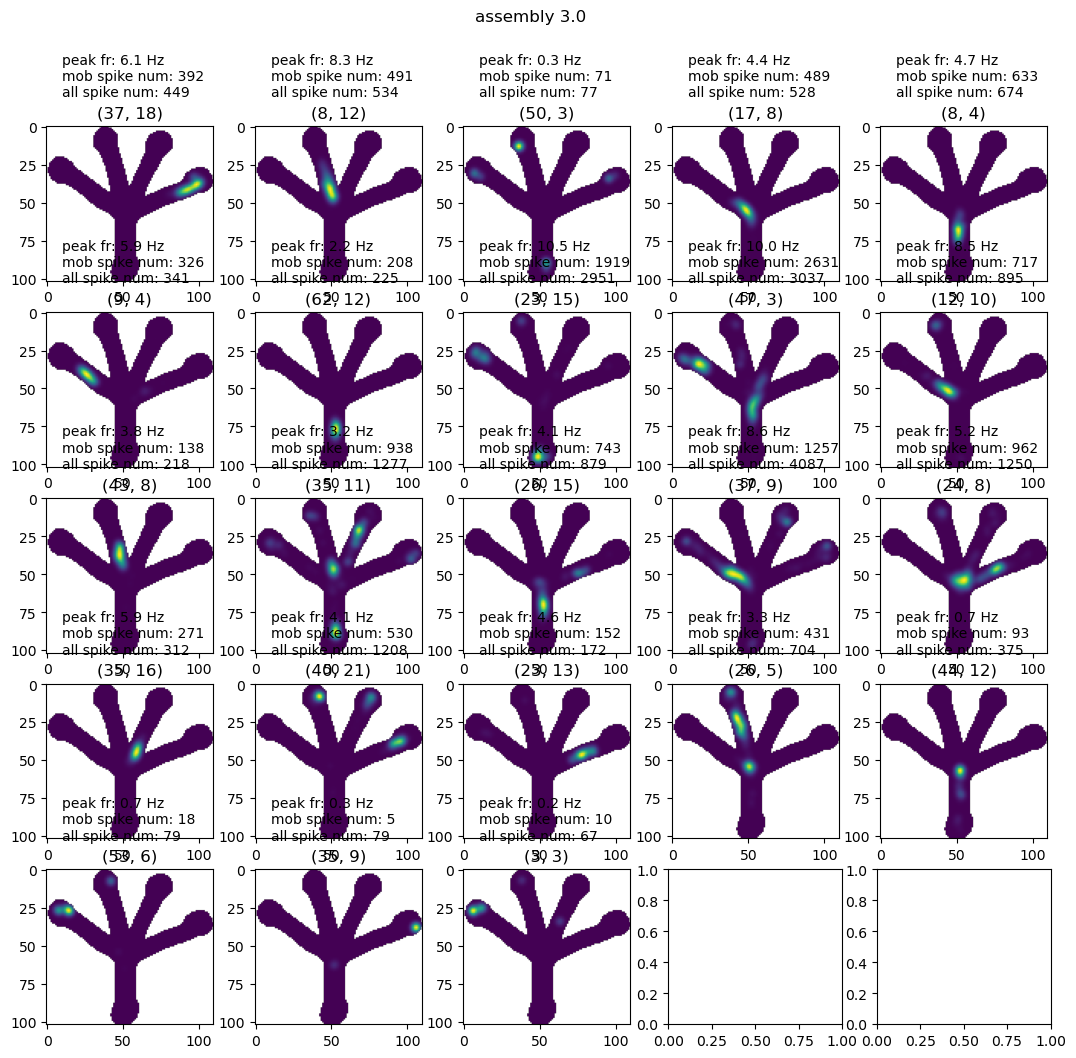

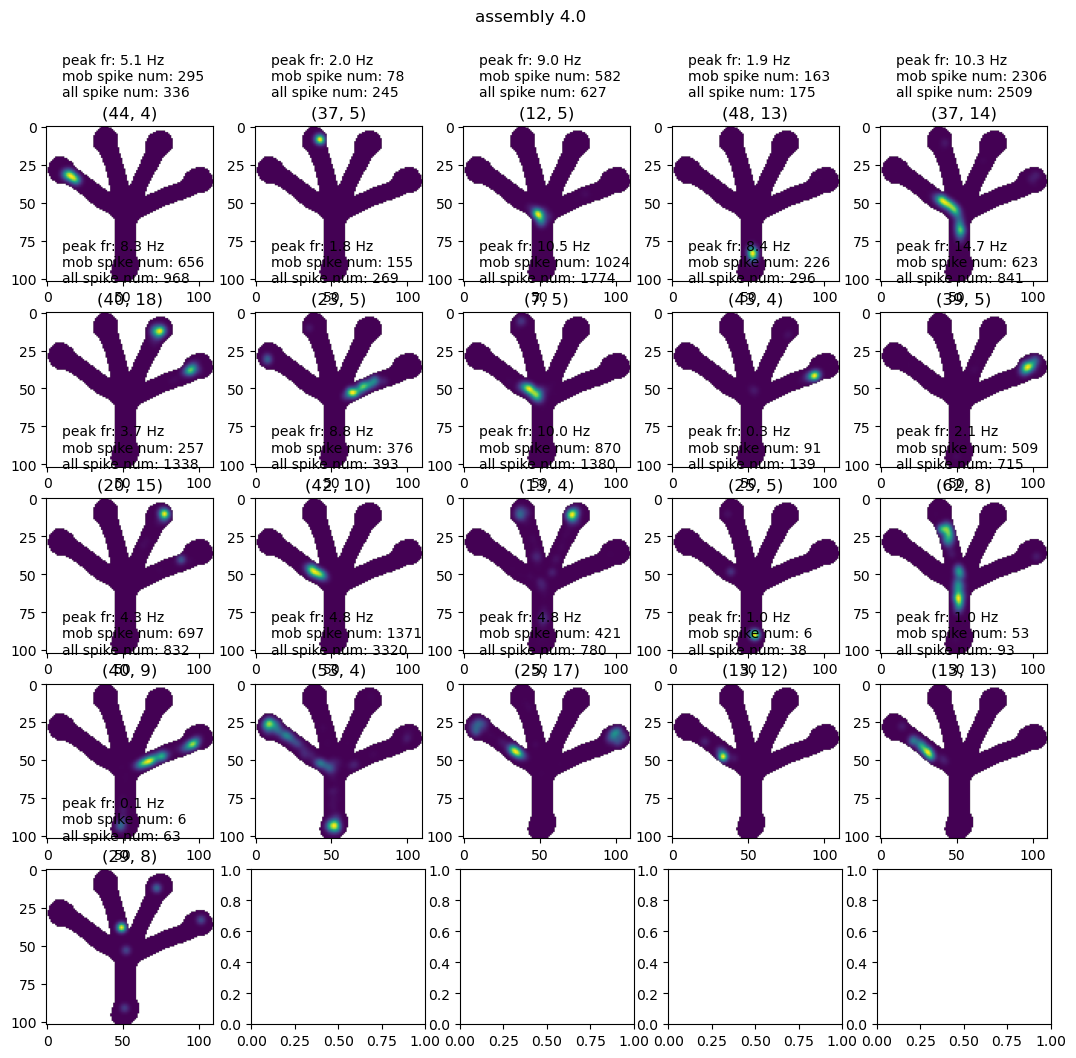

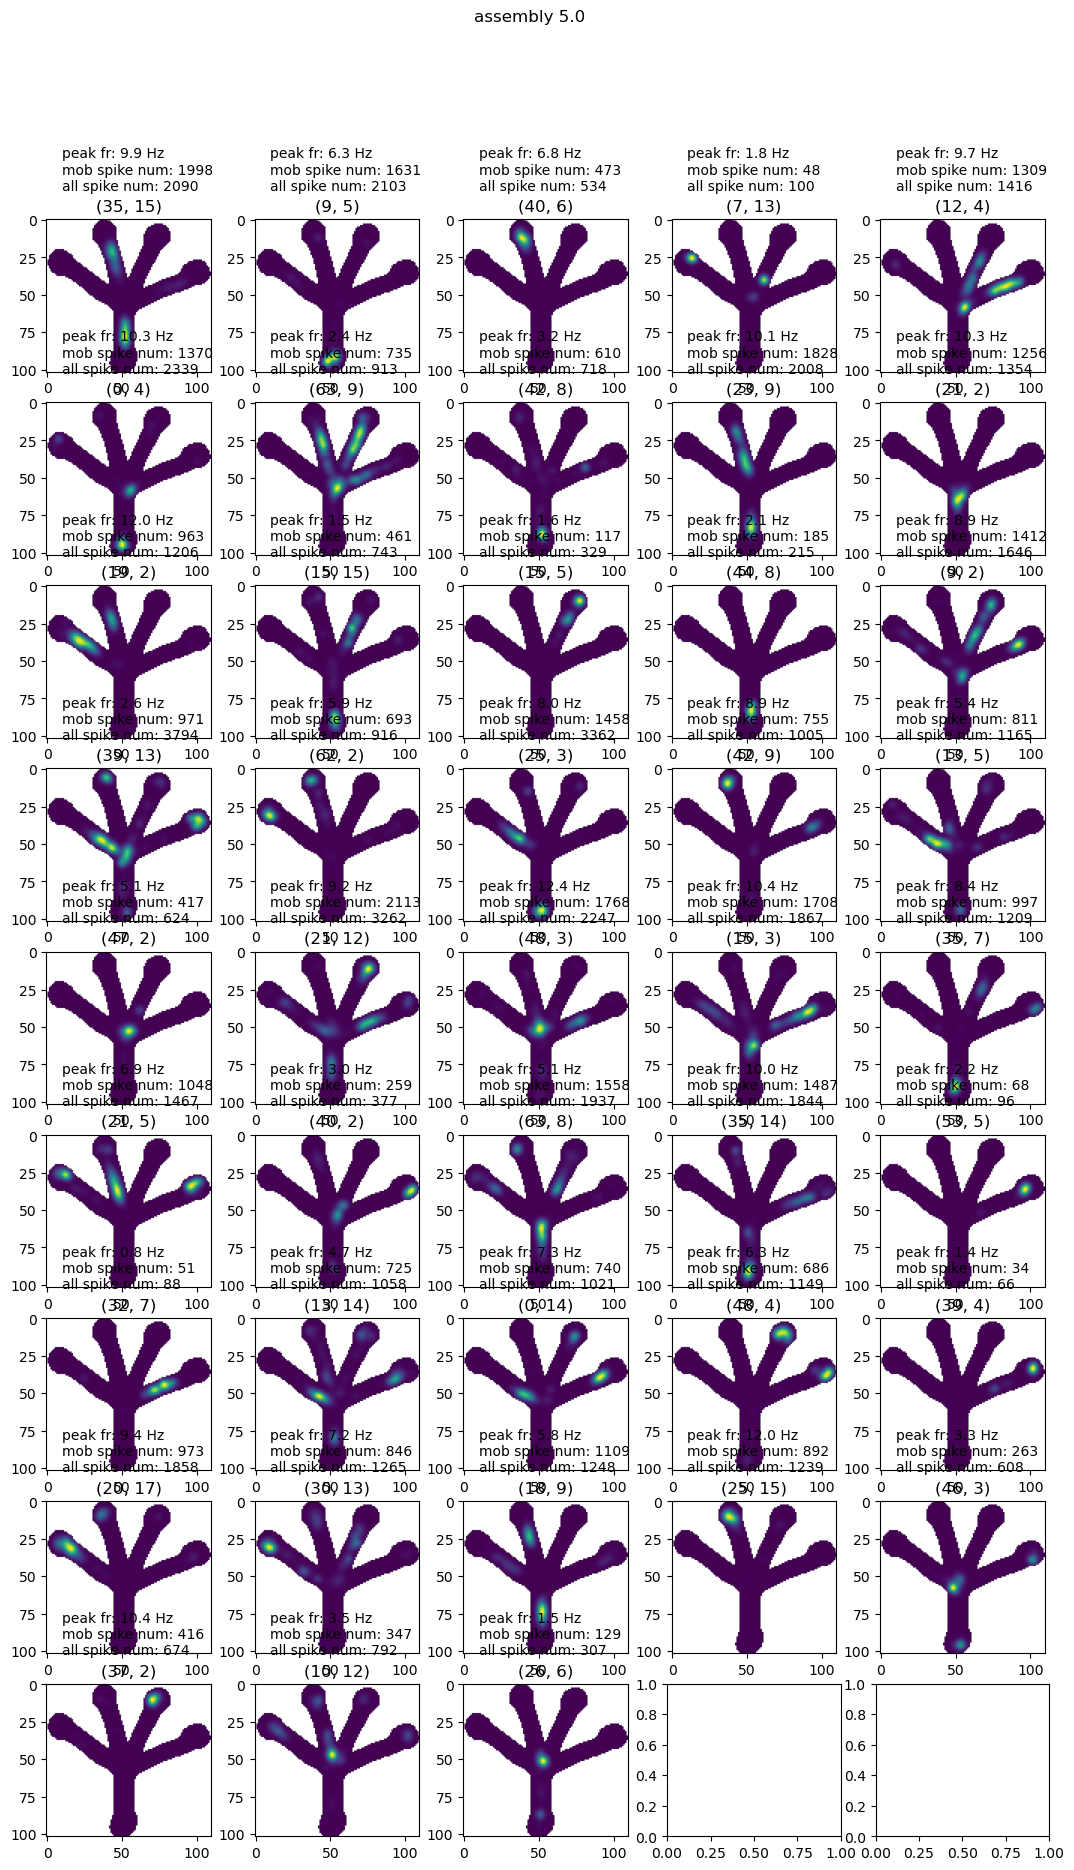

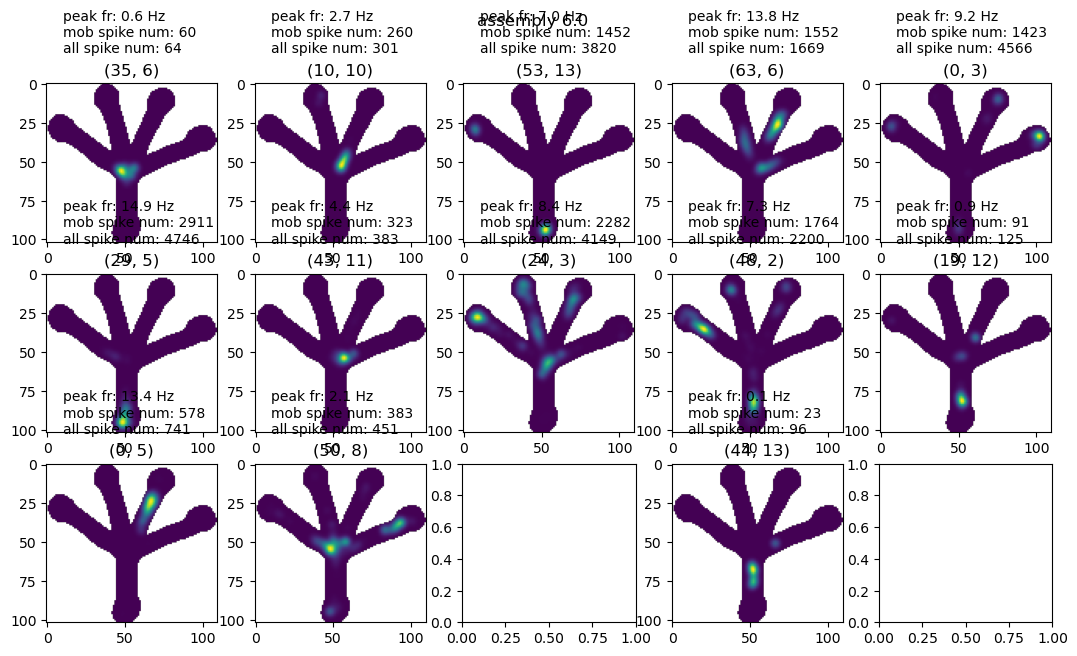

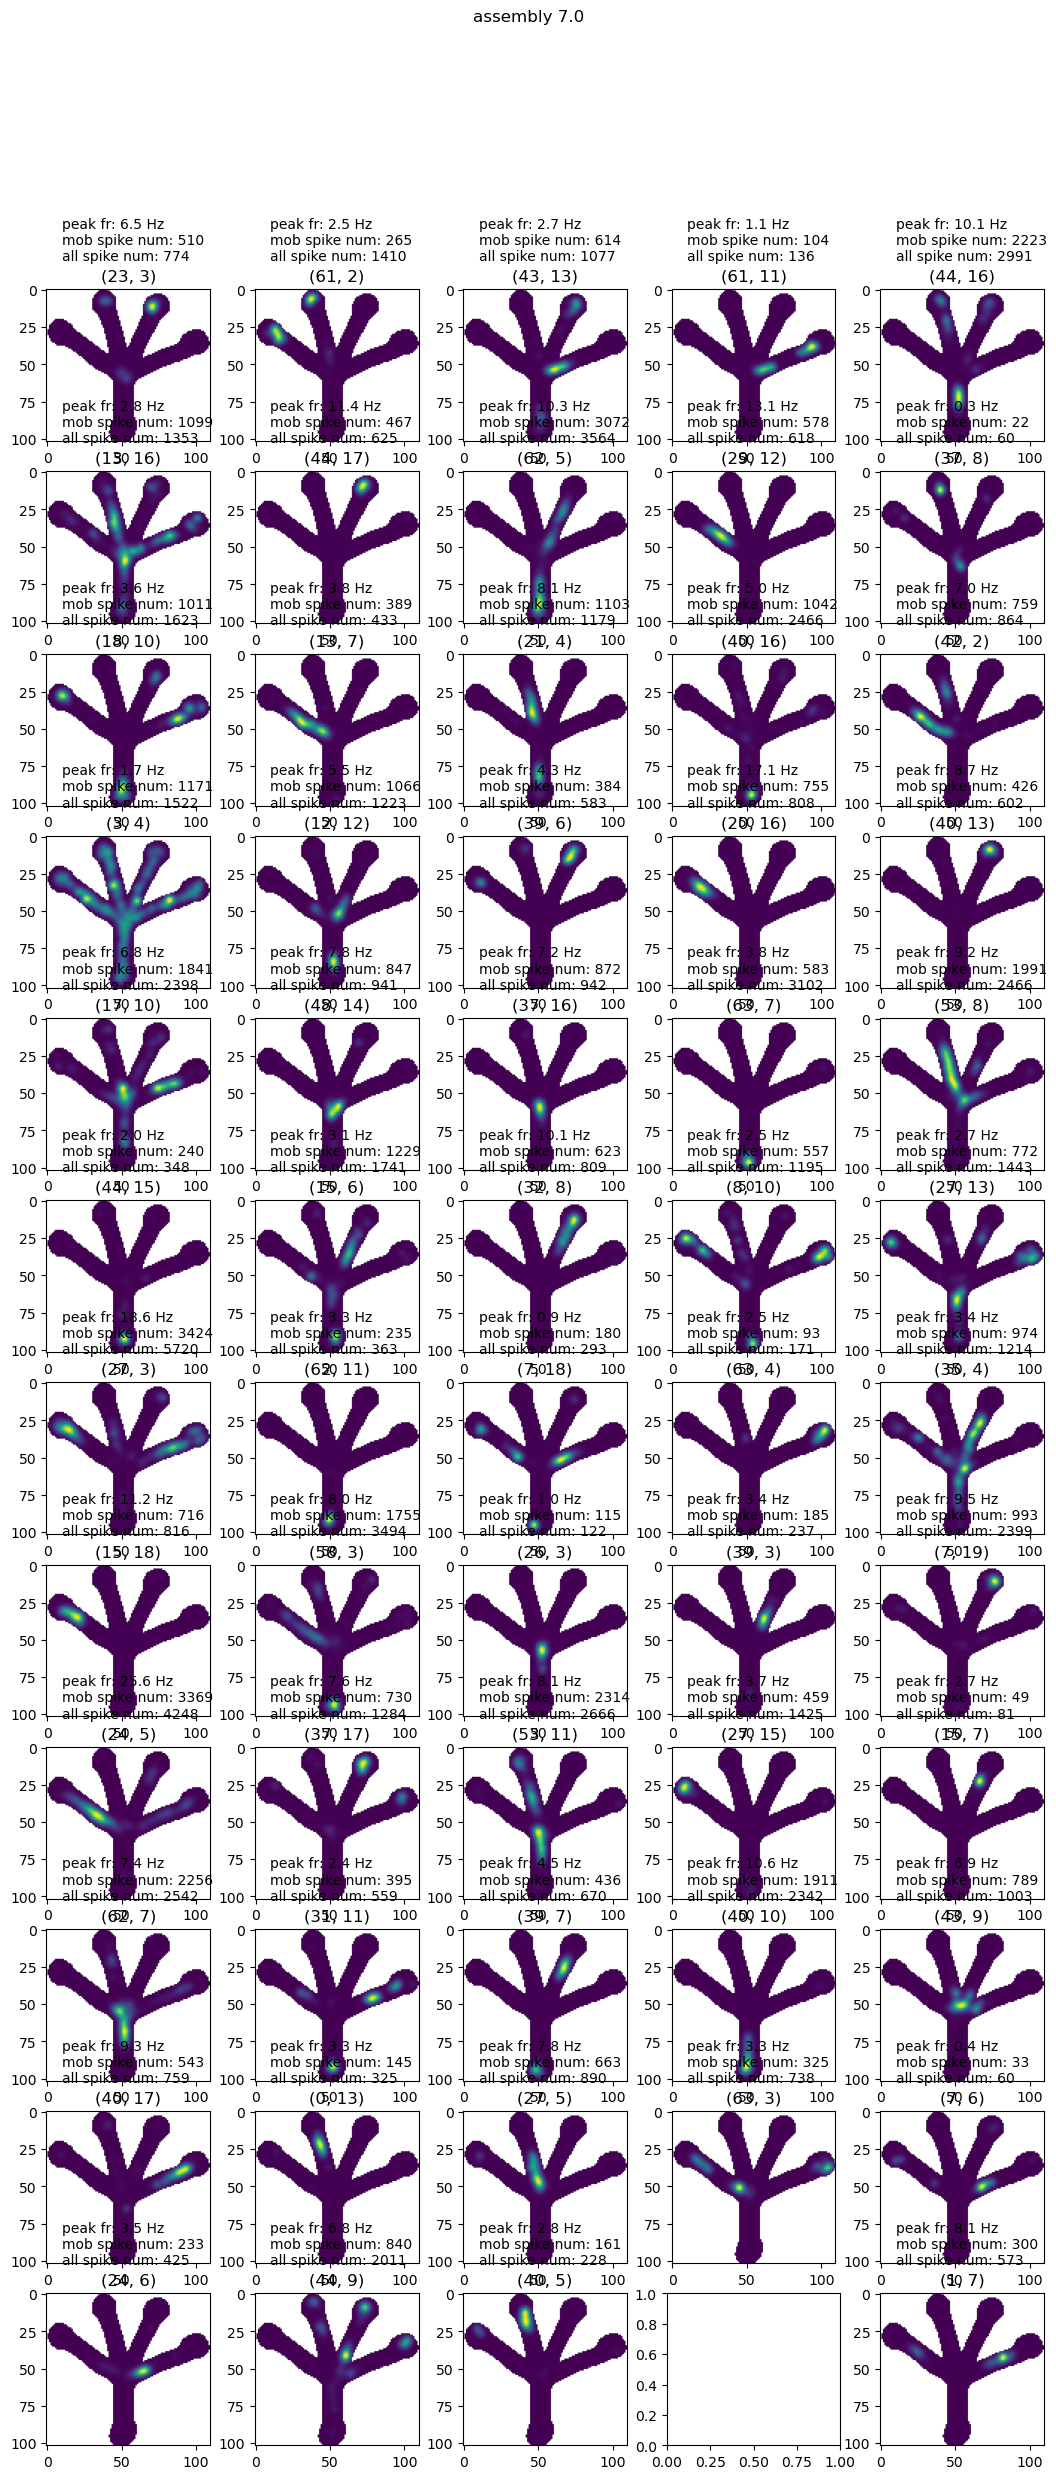

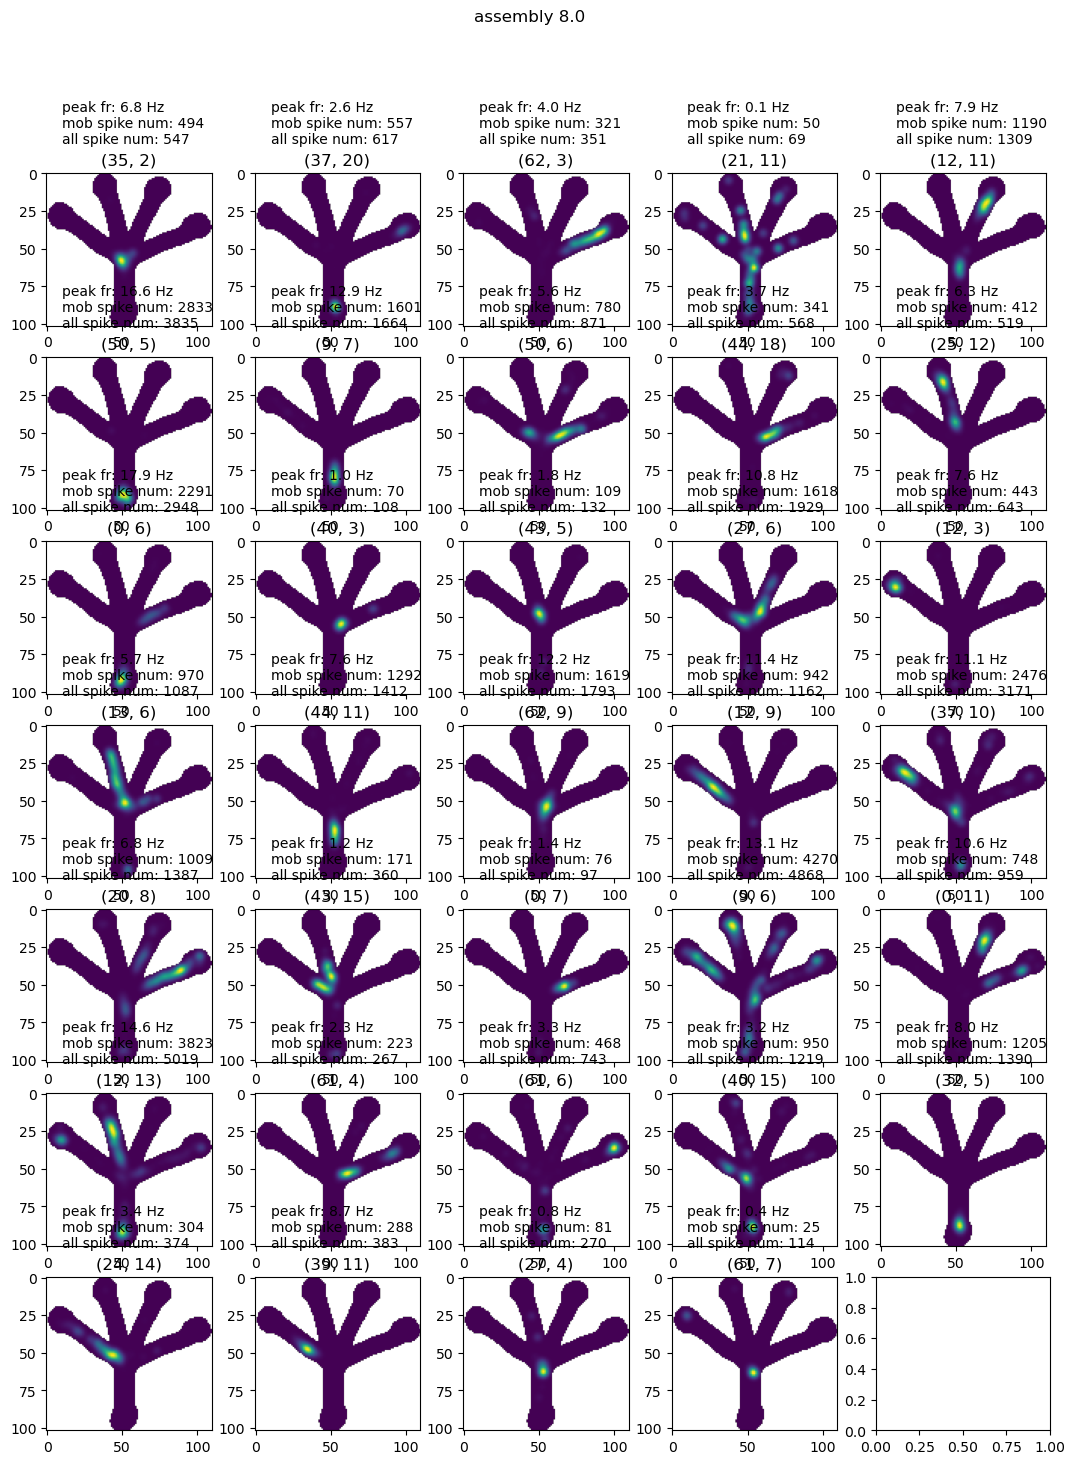

In [148]:
# each assembly plot its assembly neurons
for assembly in np.unique(neurons_labels_all_assembly):
    cell_list_assembly = [cell_list_nonan[u] for u in neurons_ind_all_assembly[neurons_labels_all_assembly == assembly]]
    
    row_num = int(np.ceil(len(cell_list_assembly)/5))
    fig, axes = plt.subplots(row_num,5, figsize = (13,7 * row_num/3), squeeze = True)

    ind = 0
    for p in np.arange(len(cell_list_assembly)):
        
        (e,u) = cell_list_assembly[p]
        try:
            axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)])
            axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u)))
            axes[np.unravel_index(ind, axes.shape)].text(10,-20,"peak fr: "+str(round(peak_frs[(e,u)],1))+" Hz \n" + 
                                                     "mob spike num: "+str(mobility_spike_counts[e,u]) + "\n" +
                                                     "all spike num: "+str(all_spike_counts[e,u]))
        except:
            pass
        
        ind = ind + 1
    
    for p in np.arange(ind, 10):
        axes[np.unravel_index(p, axes.shape)].set_axis_off()
    plt.suptitle("assembly " + str(assembly))

### Spectral Cluster in time direction

In [275]:
'''then use sklearn package'''
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=4,affinity='nearest_neighbors',n_neighbors=50) #n_neighbors=10
X_transformed = embedding.fit_transform(R)
X_transformed.shape

(3671, 4)

In [246]:
N = embedding.affinity_matrix_.toarray()
N_reorders,arm_breaks = reorder_affinity_by_arm(N,arm,linearized_location)

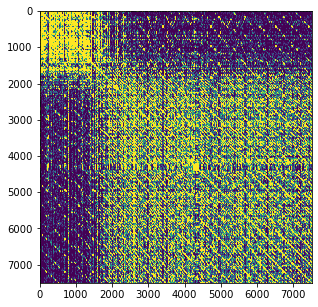

In [247]:
%matplotlib inline
fig,axes=plt.subplots(1,1,figsize=(5,5))
plt.imshow(N,vmax=0.01,interpolation='bilinear', rasterized=False)

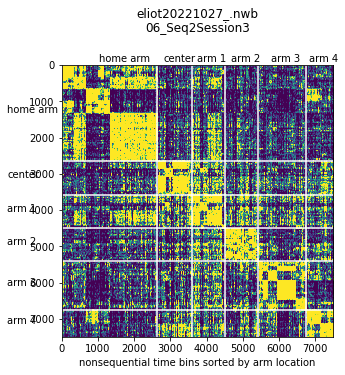

In [248]:
%matplotlib inline
fig,axes=plt.subplots(1,1,figsize=(5,5))
plt.imshow(N_reorders,vmax=0.01,interpolation='bilinear', rasterized=False)
arms_name = ['home arm','center','arm 1','arm 2','arm 3','arm 4']
a_ind=0
for a_ind in range(len(arms_name)):
    b = arm_breaks[a_ind]
    plt.axvline(b,color='w')
    plt.axhline(b,color='w')
    plt.text(-1500,0.5*(b+arm_breaks[a_ind+1]),arms_name[a_ind])
    plt.text(0.5*(b+arm_breaks[a_ind+1])-300,-100,arms_name[a_ind])
axes.set_xlabel('nonsequential time bins sorted by arm location')
figureName=nwb_copy_file_name+'_'+session_name
plt.title(nwb_copy_file_name+'\n'+session_name,y=1.1)
plt.savefig(outputFolder+figureName+'.png', dpi=300,bbox_inches='tight')
plt.savefig(outputFolder+figureName+'.pdf', dpi=300,bbox_inches='tight')

In [276]:
# color code by arms
color_palet[0,:] = [0.5,0.5,0.5]
color_palet[5,:] = [0.6,0.2,0.2]
colors_arm=[]
for t_ind in range(R.shape[0]):
    colors_arm.append(color_palet[arm[t_ind],:])

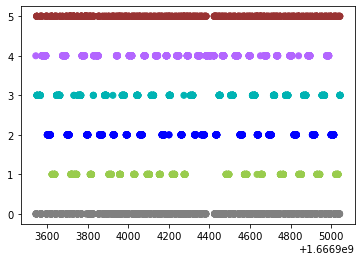

In [277]:
%matplotlib inline
plt.scatter(time_axis,arm,color=colors_arm)

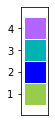

In [199]:
fig,axes=plt.subplots(1,1,figsize=(0.5,2))
for i in range(1,5):
    plt.scatter(1,i,color=color_palet[i,:],s=400,marker='s');
axes.get_xaxis().set_ticks([]);
plt.ylim(0, 5)
axes.get_yaxis().set_ticks([1,2,3,4]);

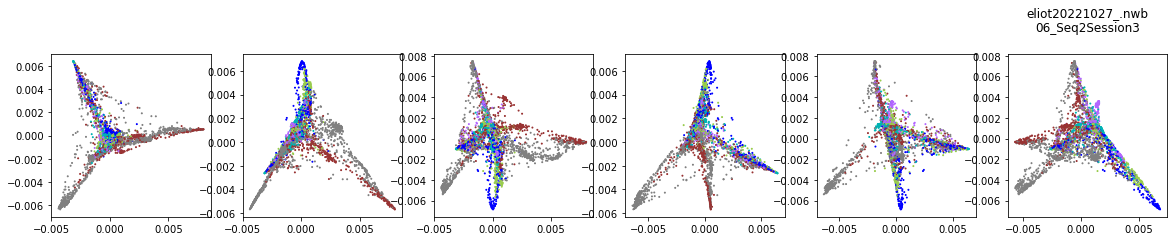

In [278]:
%matplotlib inline

fig,axes=plt.subplots(1,6,figsize=(20,3))

axes[0].scatter(X_transformed[:,0],X_transformed[:,1],color=colors_arm,s=1)
axes[1].scatter(X_transformed[:,0],X_transformed[:,2],color=colors_arm,s=1)
axes[2].scatter(X_transformed[:,0],X_transformed[:,3],color=colors_arm,s=1)
axes[3].scatter(X_transformed[:,1],X_transformed[:,2],color=colors_arm,s=1)
axes[4].scatter(X_transformed[:,1],X_transformed[:,3],color=colors_arm,s=1)
axes[5].scatter(X_transformed[:,2],X_transformed[:,3],color=colors_arm,s=1)

figureName=nwb_copy_file_name+'_'+session_name+'_Laplacian'
plt.title(nwb_copy_file_name+'\n'+session_name,y=1.1)
plt.savefig(outputFolder+figureName+'.png', dpi=300,bbox_inches='tight')
plt.savefig(outputFolder+figureName+'.pdf', dpi=300,bbox_inches='tight')


### Color result by time

In [318]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

colors=[]
for t_ind in range(len(time_axis)-1):
    colors.append(cm.jet(t_ind/len(time_axis)))

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


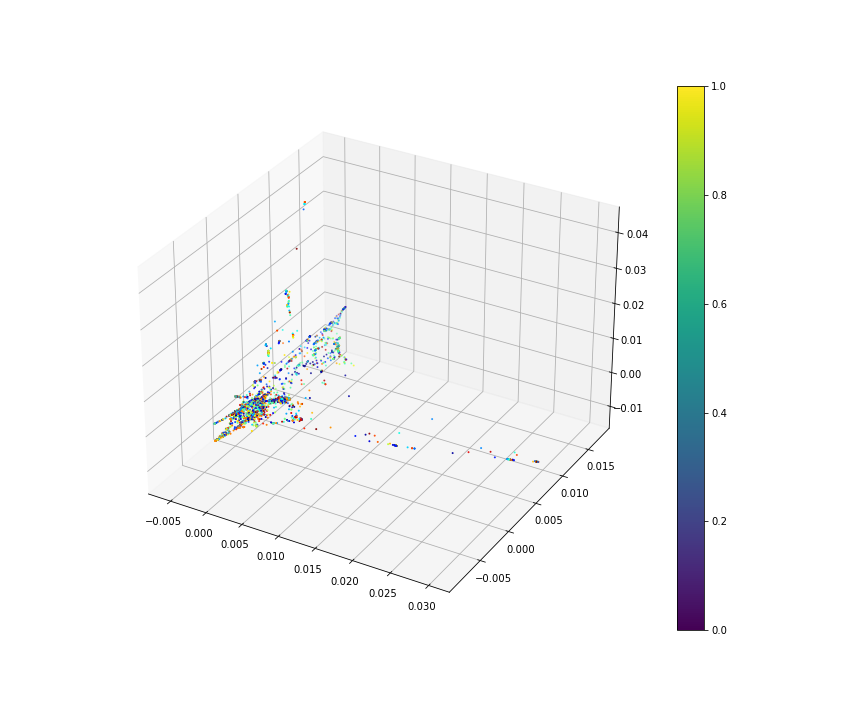

In [319]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],color=colors,s=1)
plt.colorbar(plot)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


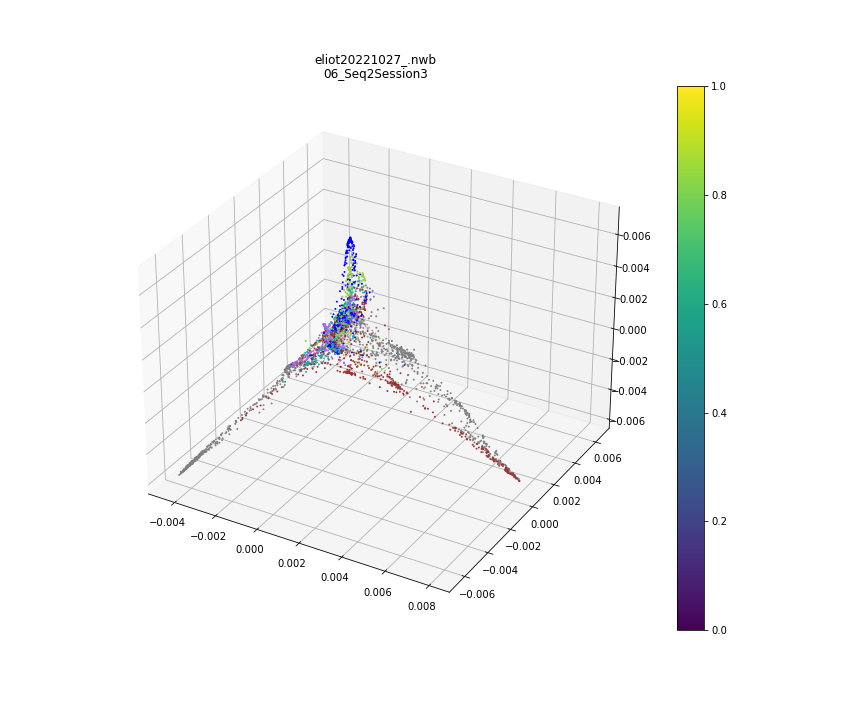

In [279]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],color=colors_arm,s=1)
plt.colorbar(plot)

figureName=nwb_copy_file_name+'_'+session_name+'_Laplacian3D'
plt.title(nwb_copy_file_name+'\n'+session_name,y=1.1)
plt.savefig(outputFolder+figureName+'.png', dpi=300,bbox_inches='tight')
plt.savefig(outputFolder+figureName+'.pdf', dpi=300,bbox_inches='tight')

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


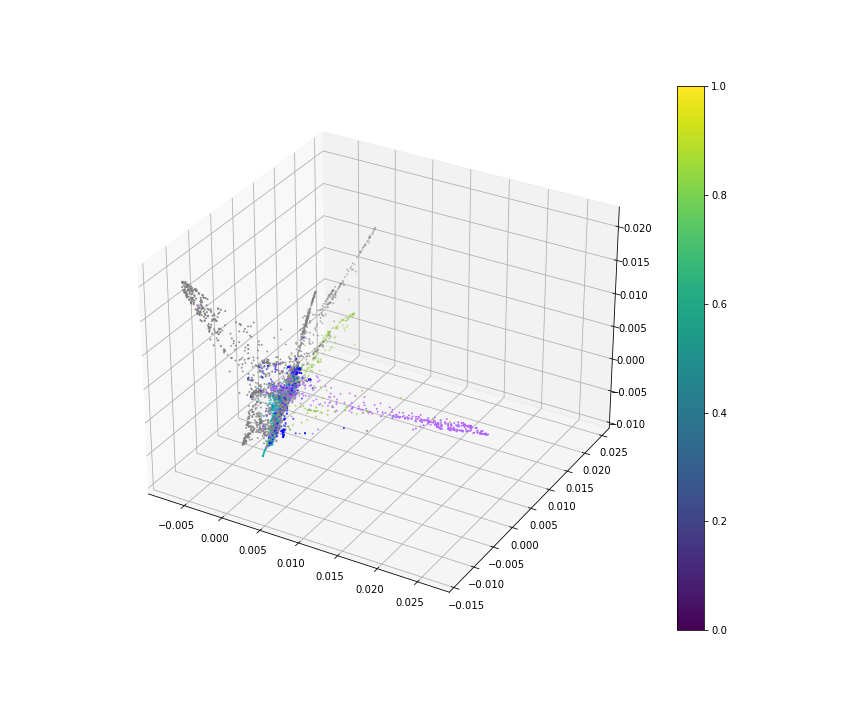

In [596]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,1],X_transformed[:,2],X_transformed[:,3],color=colors_arm,s=1)
plt.colorbar(plot)

#### (2) Find cell groups

In [409]:
loading = X_transformed.T @ R

In [410]:
C_embedding = SpectralEmbedding(n_components=3,affinity='nearest_neighbors',n_neighbors=10)
C_transformed = C_embedding.fit_transform(loading.T)
C_transformed.shape

(63, 3)

In [411]:
order = []
cell_group = np.argmax(C_transformed.T,axis=0)
for g in range(C_transformed.shape[1]):
    subordering = np.argsort(-C_transformed[cell_group == g,g])
    order.append(np.argwhere(cell_group == g).ravel()[subordering])
cell_ind=np.hstack(order)
block_boundary=np.argwhere(np.diff(cell_group[cell_ind])).ravel()+1

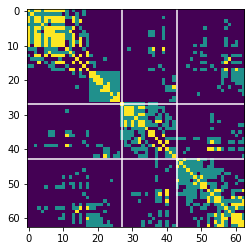

In [412]:
N = C_embedding.affinity_matrix_.toarray() #np.cov(R.T)
plt.imshow(N[cell_ind][:,cell_ind])
for b in block_boundary:
    plt.axvline(b,color='w')
    plt.axhline(b,color='w')

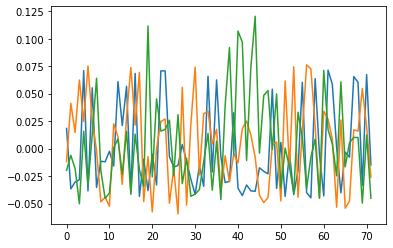

In [152]:
plt.plot(C_transformed)

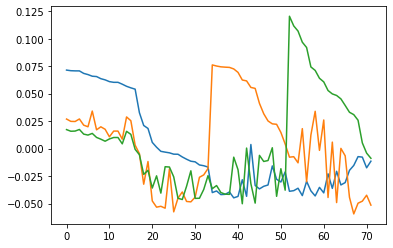

In [153]:
plt.plot(C_transformed[cell_ind,:])

### UMAP

In [280]:
R.shape

(3671, 72)

In [281]:
import umap
reducer = umap.UMAP(n_neighbors=40,min_dist=0.3,n_components=3,metric='cosine') #local_connectivity=15, #40 for early learning
embedding = reducer.fit_transform(R)
embedding.shape

(3671, 3)

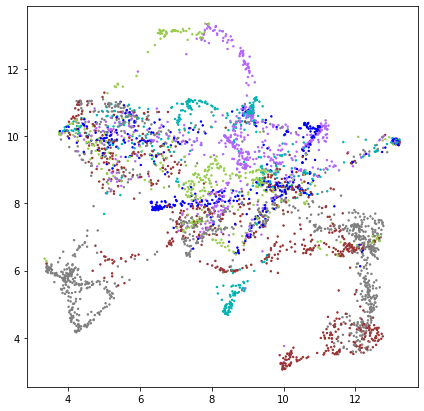

In [282]:
%matplotlib inline

fig,axes=plt.subplots(1,1,figsize=(7,7))

axes.scatter(embedding[:,0],embedding[:,1],color=colors_arm,s=2)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


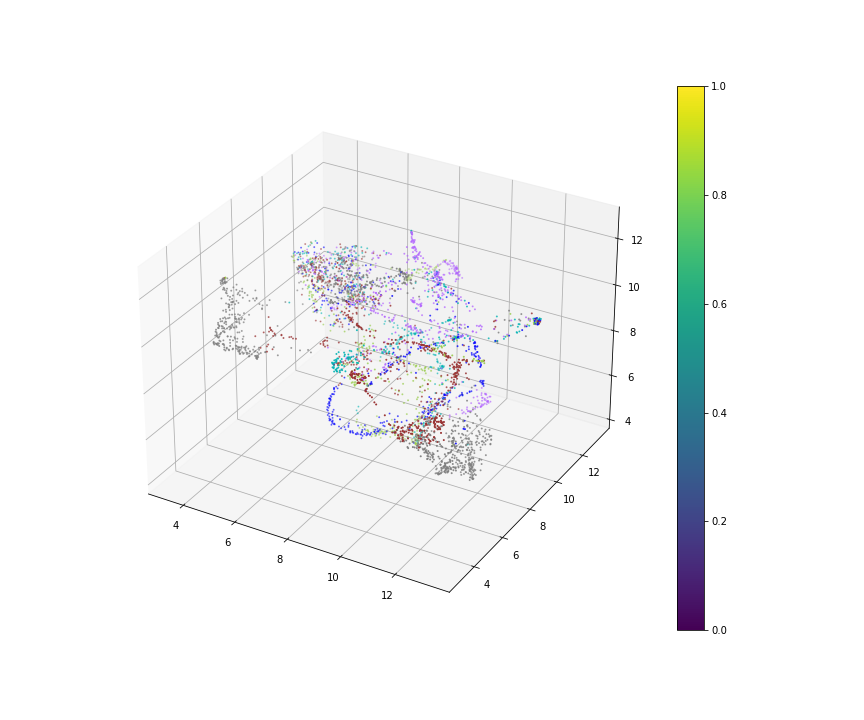

In [283]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(embedding[:,0],embedding[:,1],embedding[:,2],color=colors_arm,s=1)
plt.colorbar(plot)

In [284]:
import umap
reducer = umap.UMAP(n_neighbors=50,min_dist=0.25,metric='cosine',output_metric='haversine',n_components=2) #min_dist=0.2 #local_connectivity=15
embedding = reducer.fit_transform(R)
embedding.shape

(3671, 2)

In [285]:
x = np.sin(embedding[:, 0]) * np.cos(embedding[:, 1])
y = np.sin(embedding[:, 0]) * np.sin(embedding[:, 1])
z = np.cos(embedding[:, 0])

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


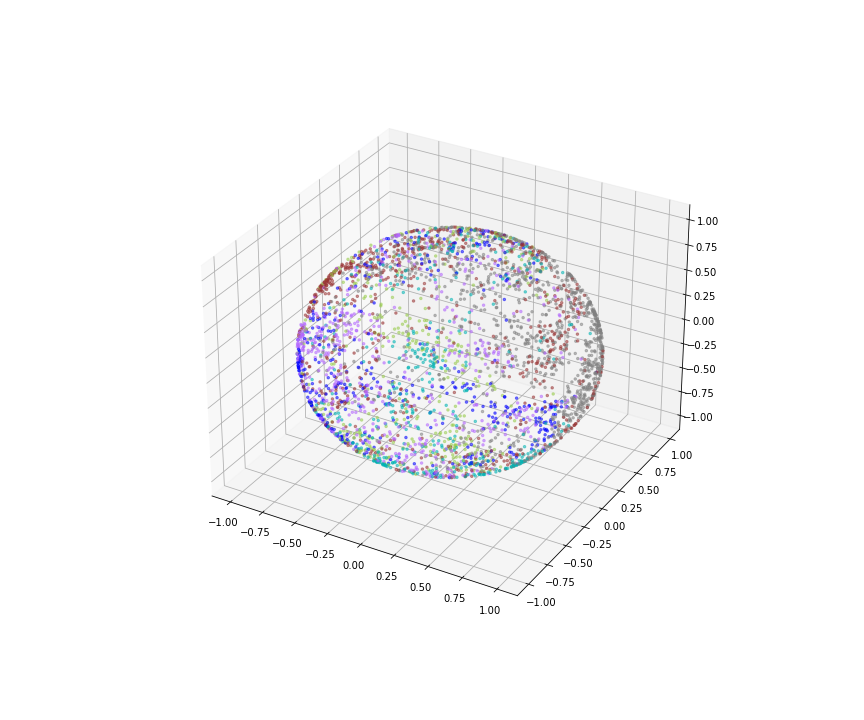

In [286]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

ax.scatter(x,y,z,color=colors_arm,s=6,alpha=0.5)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


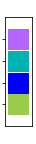

In [603]:
fig,axes=plt.subplots(1,1,figsize=(0.5,2))
for i in range(1,5):
    plt.scatter(1,i,color=color_palet[i,:],s=400,marker='s');
axes.get_xaxis().set_ticks([]);
plt.ylim(0, 5)
axes.get_yaxis().set_ticks([1,2,3,4]);

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],color=colors_arm,s=1)
plt.colorbar(plot)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


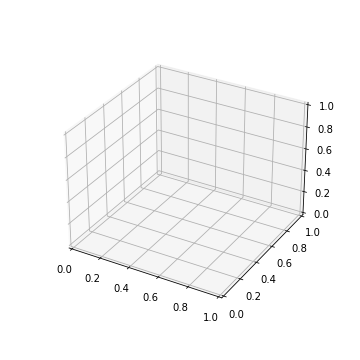

In [50]:
%matplotlib notebook
#widget
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import time

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

def animation(i):
    ax.scatter(X_transformed[i,1],X_transformed[i,2],X_transformed[i,3],color='k')
    
ani = FuncAnimation(fig, animation, frames=len(X_transformed[:,1]),interval=20)
plt.show()


## END HERE

### Spectrial Clustering in cell direction

In [440]:
## unused
'''then use sklearn package'''
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=10,affinity='nearest_neighbors',n_neighbors=10)
X_transformed = embedding.fit_transform(R.T)
X_transformed.shape

def pick_high_ind(value):
    # also in the order of descending value
    sort_ind = np.argsort(-value)
    return sort_ind[value[sort_ind]>=np.quantile(value,0.95)]

ind = []
arm_ind=[]
for i in range(10):
    ind.append(pick_high_ind(embedding.embedding_[:,i]))
    arm_ind.append(np.ones(len(pick_high_ind(X_transformed[:,i])))*i)
ind=np.concatenate(ind)
arm_ind=np.concatenate(arm_ind)

_, idx = np.unique(ind, return_index=True)
ind = ind[np.sort(idx)]
arm_ind_ = arm_ind[np.sort(idx)]

arm_breaks=np.argwhere(np.diff(arm_ind_)).ravel()+1
arm_breaks=np.concatenate(([0],arm_breaks))

N=embedding.affinity_matrix_.toarray()
N_=N[ind,:]
N_=N_[:,ind]
%matplotlib inline
fig,axes=plt.subplots(1,1,figsize=(5,5))
plt.imshow(N_)
for b in arm_breaks:
    plt.axvline(b,color='w')
    plt.axhline(b,color='w')

(51, 10)